In [1]:
import torch as t
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from math import sqrt
import itertools
from torchvision.ops import RoIPool
from torchvision.ops import nms
from dataclasses import dataclass
import random
import imageio
from pathlib import Path
from typing import List
from typing import Tuple
from collections import defaultdict
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageColor
from tqdm import tqdm
import pandas as pd



In [2]:
@dataclass
class Box:
  class_index: int
  class_name: str
  corners: np.ndarray
  
  def __repr__(self):
    return "[class=%s (%f,%f,%f,%f)]" % (self.class_name, self.corners[0], self.corners[1], self.corners[2], self.corners[3])

  def __str__(self):
    return repr(self)

@dataclass
class TrainingSample:
  anchor_map:                 np.ndarray                # shape (feature_map_height,feature_map_width,num_anchors*4), with each anchor as [center_y,center_x,height,width]
  anchor_valid_map:           np.ndarray                # shape (feature_map_height,feature_map_width,num_anchors), indicating which anchors are valid (do not cross image boundaries)
  gt_rpn_map:                 np.ndarray                # TODO: describe me
  gt_rpn_object_indices:      List[Tuple[int,int,int]]  # list of (y,x,k) coordinates of anchors in gt_rpn_map that are labeled as object
  gt_rpn_background_indices:  List[Tuple[int,int,int]]  # list of (y,x,k) coordinates of background anchors
  gt_boxes:                   List[Box]                 # list of ground-truth boxes, scaled
  image_data:                 np.ndarray                # shape (3,height,width), pre-processed and scaled to size expected by model
  image:                      Image                     # PIL image data (for debug rendering), scaled
  filepath:                   str                       # file path of image

In [3]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def _compute_scale_factor(original_width, original_height, min_dimension_pixels):
  if not min_dimension_pixels:
    return 1.0
  if original_width > original_height:
    scale_factor = min_dimension_pixels / original_height
  else:
    scale_factor = min_dimension_pixels / original_width
  return scale_factor

def _preprocess_vgg16(image_data):
  image_data = image_data[:, :, ::-1]           # RGB -> BGR
  image_data[:, :, 0] -= 103.939                # ImageNet B mean
  image_data[:, :, 1] -= 116.779                # ImageNet G mean
  image_data[:, :, 2] -= 123.680                # ImageNet R mean 
  image_data = image_data.transpose([2, 0, 1])  # (height,width,3) -> (3,height,width)
  return image_data.copy()                      # copy required to eliminate negative stride (which Torch doesn't like)

def load_image(url, min_dimension_pixels = None, horizontal_flip = False):
  """
  Loads and preprocesses an image for use with VGG-16, which consists of
  converting RGB to BGR and subtracting ImageNet dataset means from each
  component. The image can be resized so that the minimum dimension is a
  defined size, as recommended by Faster R-CNN. 
  Parameters
  ----------
  url : str
    URL (local or remote file) to load.
  min_dimension_pixels : int
    If not None, specifies the size in pixels of the smaller side of the image.
    The other side is scaled proportionally.
  horizontal_flip : bool
    Whether to flip the image horizontally.
  Returns
  -------
  np.ndarray, PIL.Image, float, Tuple[int, int, int]
    Image pixels as float32, shaped as (channels, height, width); an image
    object suitable for drawing and visualization; scaling factor applied to
    the image dimensions; and the original image shape.
  """
  data = imageio.imread(url, pilmode = "RGB")
  image = Image.fromarray(data, mode = "RGB")
  original_width, original_height = image.width, image.height
  if horizontal_flip:
    image = image.transpose(method = Image.FLIP_LEFT_RIGHT)
  if min_dimension_pixels is not None:
    scale_factor = _compute_scale_factor(original_width = image.width, original_height = image.height, min_dimension_pixels = min_dimension_pixels)
    width = int(image.width * scale_factor)
    height = int(image.height * scale_factor)
    image = image.resize((width, height), resample = Image.BILINEAR)
  else:
    scale_factor = 1.0
  image_data = np.array(image).astype(np.float32)
  image_data = _preprocess_vgg16(image_data = image_data)
  return image_data, image, scale_factor, (image_data.shape[0], original_height, original_width)

In [5]:
class Dataset:
  """
  A VOC dataset iterator for a particular split (train, val, etc.)
  """

  num_classes = 10
  class_index_to_name = {
    0:  "background",
    1:  "keepRight",
    2:  "merge",
    3:  "pedestrianCrossing",
    4:  "signalAhead",
    5:  "speedLimit25",
    6:  "speedLimit35",
    7:  "stop",
    8:  "yield",
    9:  "yieldAhead",
  }

  def __init__(self, split, dir = "lisa_resize/db_lisa_tiny", feature_pixels = 16, augment = True, shuffle = True, allow_difficult = False, cache = True):
    """
    Parameters
    ----------
    split : str
      Dataset split to load: train, val, or trainval.
    dir : str
      Root directory of dataset.
    feature_pixels : int
      Size of each cell in the Faster R-CNN feature map (i.e., VGG-16 feature
      extractor output) in image pixels. This is the separation distance
      between anchors.
    augment : bool
      Whether to randomly augment (horizontally flip) images during iteration
      with 50% probability.
    shuffle : bool
      Whether to shuffle the dataset each time it is iterated.
    allow_difficult : bool
      Whether to include ground truth boxes that are marked as "difficult".
    cache : bool
      Whether to training samples in memory after first being generated.
    """
    # if not os.path.exists(dir):
    #   raise FileNotFoundError("Dataset directory does not exist: %s" % dir)
    self.split = split
    #self._dir = dir
    self.class_index_to_name = self._get_classes()
    self.class_name_to_index = { class_name: class_index for (class_index, class_name) in self.class_index_to_name.items() }
    self.num_classes = len(self.class_index_to_name)
    assert self.num_classes == Dataset.num_classes, "Dataset does not have the expected number of classes (found %d but expected %d)" % (self.num_classes, Dataset.num_classes)
    assert self.class_index_to_name == Dataset.class_index_to_name, "Dataset does not have the expected class mapping"
    self._filepaths = self._get_filepaths()
    self.num_samples = len(self._filepaths)
    self._gt_boxes_by_filepath = self._get_ground_truth_boxes(filepaths = self._filepaths, allow_difficult = allow_difficult) 
    self._i = 0
    self._iterable_filepaths = self._filepaths.copy()
    self._feature_pixels = feature_pixels
    self._augment = augment
    self._shuffle = shuffle
    self._cache = cache
    self._unaugmented_cached_sample_by_filepath = {}
    self._augmented_cached_sample_by_filepath = {}

  def __iter__(self):
    self._i = 0
    if self._shuffle:
      random.shuffle(self._iterable_filepaths)
    return self

  def __next__(self):
    if self._i >= len(self._iterable_filepaths):
      raise StopIteration

    # Next file to load
    filepath = self._iterable_filepaths[self._i]
    self._i += 1

    # Augment?
    flip = random.randint(0, 1) != 0 if self._augment else 0
    cached_sample_by_filepath = self._augmented_cached_sample_by_filepath if flip else self._unaugmented_cached_sample_by_filepath
  
    # Load and, if caching, write back to cache
    if filepath in cached_sample_by_filepath:
      sample = cached_sample_by_filepath[filepath]
    else:
      sample = self._generate_training_sample(filepath = filepath, flip = flip)
    if self._cache:
      cached_sample_by_filepath[filepath] = sample

    # Return the sample
    return sample

  def _generate_training_sample(self, filepath, flip):
    # Load and preprocess the image
    scaled_image_data, scaled_image, scale_factor, original_shape = load_image(url = filepath, min_dimension_pixels = None, horizontal_flip = flip)
    _, original_height, original_width = original_shape

    # Scale ground truth boxes to new image size
    scaled_gt_boxes = []
    for box in self._gt_boxes_by_filepath[filepath]:
      if flip:
        corners = np.array([
          box.corners[0],
          original_width - 1 - box.corners[3],
          box.corners[2],
          original_width - 1 - box.corners[1]
        ]) 
      else:
        corners = box.corners
      scaled_box = Box(
        class_index = box.class_index,
        class_name = box.class_name,
        corners = corners * scale_factor 
      )
      scaled_gt_boxes.append(scaled_box)

    # Generate anchor maps and RPN truth map
    anchor_map, anchor_valid_map = generate_anchor_maps(image_shape = scaled_image_data.shape, feature_pixels = self._feature_pixels)
    gt_rpn_map, gt_rpn_object_indices, gt_rpn_background_indices = generate_rpn_map(anchor_map = anchor_map, anchor_valid_map = anchor_valid_map, gt_boxes = scaled_gt_boxes)

    # Return sample
    return TrainingSample(
      anchor_map = anchor_map,
      anchor_valid_map = anchor_valid_map,
      gt_rpn_map = gt_rpn_map,
      gt_rpn_object_indices = gt_rpn_object_indices,
      gt_rpn_background_indices = gt_rpn_background_indices,
      gt_boxes = scaled_gt_boxes,
      image_data = scaled_image_data,
      image = scaled_image,
      filepath = filepath
    )

  def _get_classes(self):
    imageset_dir = "annotations_FasterRCNN.csv"
    anno = pd.read_csv(imageset_dir)
    classes = set( anno["class"] )
    assert len(classes) > 0, "No classes found in ImageSets/Main"
    class_index_to_name = { (1 + v[0]): v[1] for v in enumerate(sorted(classes)) }
    class_index_to_name[0] = "background"
    return class_index_to_name

  def _get_filepaths(self):
    imageset_dir = "annotations_FasterRCNN.csv"
    anno = pd.read_csv(imageset_dir)
    image_paths = []
    for index, row in anno.iterrows():
      if row["Train/Test"] == self.split:
        image_paths.append(row["filename"])
        
    return image_paths



  def _get_ground_truth_boxes(self, filepaths, allow_difficult):
    gt_boxes_by_filepath = {}
    imageset_dir = "annotations_FasterRCNN.csv"
    anno = pd.read_csv(imageset_dir)

  

    for index, row in anno.iterrows():
      if row["Train/Test"] == self.split:
        boxes = []
        x_min = row["x1"]      
        y_min = row["y1"]
        x_max = row["x2"]
        y_max = row["y2"]

        class_name = row["class"]

        corners = np.array([ y_min, x_min, y_max, x_max ]).astype(np.float32)
        box = Box(class_index = self.class_name_to_index[class_name], class_name = class_name, corners = corners)
        boxes.append(box)
        assert len(boxes) > 0
        gt_boxes_by_filepath[row["filename"]] = boxes
    return gt_boxes_by_filepath

In [6]:
def intersection_over_union(boxes1, boxes2):
  """
  Computes intersection-over-union (IoU) for multiple boxes in parallel.
  Parameters
  ----------
  boxes1 : np.ndarray
    Box corners, shaped (N, 4), with each box as (y1, x1, y2, x2).
  boxes2 : np.ndarray
    Box corners, shaped (M, 4).
  Returns
  -------
  np.ndarray
    IoUs for each pair of boxes in boxes1 and boxes2, shaped (N, M).
  """
  top_left_point = np.maximum(boxes1[:,None,0:2], boxes2[:,0:2])                                  # (N,1,2) and (M,2) -> (N,M,2) indicating top-left corners of box pairs
  bottom_right_point = np.minimum(boxes1[:,None,2:4], boxes2[:,2:4])                              # "" bottom-right corners ""
  well_ordered_mask = np.all(top_left_point < bottom_right_point, axis = 2)                       # (N,M) indicating whether top_left_x < bottom_right_x and top_left_y < bottom_right_y (meaning boxes may intersect)
  intersection_areas = well_ordered_mask * np.prod(bottom_right_point - top_left_point, axis = 2) # (N,M) indicating intersection area (bottom_right_x - top_left_x) * (bottom_right_y - top_left_y)
  areas1 = np.prod(boxes1[:,2:4] - boxes1[:,0:2], axis = 1)                                       # (N,) indicating areas of boxes1
  areas2 = np.prod(boxes2[:,2:4] - boxes2[:,0:2], axis = 1)                                       # (M,) indicating areas of boxes2
  union_areas = areas1[:,None] + areas2 - intersection_areas                                      # (N,1) + (M,) - (N,M) = (N,M), union areas of both boxes
  epsilon = 1e-7
  return intersection_areas / (union_areas + epsilon)

In [7]:
def t_intersection_over_union(boxes1, boxes2):
  """
  Equivalent to intersection_over_union(), operating on PyTorch tensors.
  Parameters
  ----------
  boxes1 : torch.Tensor
    Box corners, shaped (N, 4), with each box as (y1, x1, y2, x2).
  boxes2 : torch.Tensor
    Box corners, shaped (M, 4).
  Returns
  -------
  torch.Tensor
    IoUs for each pair of boxes in boxes1 and boxes2, shaped (N, M).
  """
  top_left_point = t.maximum(boxes1[:,None,0:2], boxes2[:,0:2])                                 # (N,1,2) and (M,2) -> (N,M,2) indicating top-left corners of box pairs
  bottom_right_point = t.minimum(boxes1[:,None,2:4], boxes2[:,2:4])                             # "" bottom-right corners ""
  well_ordered_mask = t.all(top_left_point < bottom_right_point, axis = 2)                      # (N,M) indicating whether top_left_x < bottom_right_x and top_left_y < bottom_right_y (meaning boxes may intersect)
  intersection_areas = well_ordered_mask * t.prod(bottom_right_point - top_left_point, dim = 2) # (N,M) indicating intersection area (bottom_right_x - top_left_x) * (bottom_right_y - top_left_y)
  areas1 = t.prod(boxes1[:,2:4] - boxes1[:,0:2], dim = 1)                                       # (N,) indicating areas of boxes1
  areas2 = t.prod(boxes2[:,2:4] - boxes2[:,0:2], dim = 1)                                       # (M,) indicating areas of boxes2
  union_areas = areas1[:,None] + areas2 - intersection_areas                                    # (N,1) + (M,) - (N,M) = (N,M), union areas of both boxes
  epsilon = 1e-7
  return intersection_areas / (union_areas + epsilon)

In [8]:
def convert_deltas_to_boxes(box_deltas, anchors, box_delta_means, box_delta_stds):
  """
  Converts box deltas, which are in parameterized form (ty, tx, th, tw) as
  described by the Fast R-CNN and Faster R-CNN papers, to boxes
  (y1, x1, y2, x2). The anchors are the base boxes (e.g., RPN anchors or
  proposals) that the box deltas describe a modification to.
  Parameters
  ----------
  box_deltas : np.ndarray
    Box deltas with shape (N, 4). Each row is (ty, tx, th, tw).
  anchors : np.ndarray
    Corresponding anchors that the box deltas are based upon, shaped (N, 4)
    with each row being (center_y, center_x, height, width).
  box_delta_means : np.ndarray
    Mean ajustment to box deltas, (4,), to be added after standard deviation
    scaling and before conversion to actual box coordinates.
  box_delta_stds : np.ndarray
    Standard deviation adjustment to box deltas, (4,). Box deltas are first
    multiplied by these values.
  Returns
  -------
  np.ndarray
    Box coordinates, (N, 4), with each row being (y1, x1, y2, x2).
  """
  box_deltas = box_deltas * box_delta_stds + box_delta_means
  center = anchors[:,2:4] * box_deltas[:,0:2] + anchors[:,0:2]  # center_x = anchor_width * tx + anchor_center_x, center_y = anchor_height * ty + anchor_center_y
  size = anchors[:,2:4] * np.exp(box_deltas[:,2:4])             # width = anchor_width * exp(tw), height = anchor_height * exp(th)
  boxes = np.empty(box_deltas.shape)
  boxes[:,0:2] = center - 0.5 * size                            # y1, x1
  boxes[:,2:4] = center + 0.5 * size                            # y2, x2
  return boxes

In [9]:
def t_convert_deltas_to_boxes(box_deltas, anchors, box_delta_means, box_delta_stds):
  """
  Equivalent to convert_deltas_to_boxes(), operating on PyTorch tensors.
  Parameters
  ----------
  box_deltas : torch.Tensor
    Box deltas with shape (N, 4). Each row is (ty, tx, th, tw).
  anchors : torch.Tensor
    Corresponding anchors that the box deltas are based upon, shaped (N, 4)
    with each row being (center_y, center_x, height, width).
  box_delta_means : torch.Tensor
    Mean ajustment to box deltas, (4,), to be added after standard deviation
    scaling and before conversion to actual box coordinates.
  box_delta_stds : torch.Tensor
    Standard deviation adjustment to box deltas, (4,). Box deltas are first
    multiplied by these values.
  Returns
  -------
  torch.Tensor
    Box coordinates, (N, 4), with each row being (y1, x1, y2, x2).
  """
  box_deltas = box_deltas * box_delta_stds + box_delta_means
  center = anchors[:,2:4] * box_deltas[:,0:2] + anchors[:,0:2]  # center_x = anchor_width * tx + anchor_center_x, center_y = anchor_height * ty + anchor_center_y
  size = anchors[:,2:4] * t.exp(box_deltas[:,2:4])              # width = anchor_width * exp(tw), height = anchor_height * exp(th)
  boxes = t.empty(box_deltas.shape, dtype = t.float32, device = "cuda")
  boxes[:,0:2] = center - 0.5 * size                            # y1, x1
  boxes[:,2:4] = center + 0.5 * size                            # y2, x2
  return boxes

In [10]:
def _compute_anchor_sizes():
  #
  # Anchor scales and aspect ratios.
  #
  # x * y = area          x * (x_aspect * x) = x_aspect * x^2 = area
  # x_aspect * x = y  ->  x = sqrt(area / x_aspect)
  #                       y = x_aspect * sqrt(area / x_aspect)
  #
  areas = [ 64*64, 128*128, 256*256 ]   # pixels
  x_aspects = [ 0.5, 1.0, 2.0 ]           # x:1 ratio

  # Generate all 9 combinations of area and aspect ratio
  heights = np.array([ round(x_aspects[j] * sqrt(areas[i] / x_aspects[j])) for (i, j) in itertools.product(range(3), range(3)) ])
  widths = np.array([ round(sqrt(areas[i] / x_aspects[j])) for (i, j) in itertools.product(range(3), range(3)) ])

  # Return as (9,2) matrix of sizes
  return np.vstack([ heights, widths ]).T

In [11]:
def generate_anchor_maps(image_shape, feature_pixels): 
  """
  Generates maps defining the anchors for a given input image size. There are 9
  different anchors at each feature map cell (3 scales, 3 ratios).
  Parameters
  ----------
  image_shape : Tuple[int, int, int]
    Shape of the input image, (channels, height, width), at the scale it will
    be passed into the Faster R-CNN model.
  feature_pixels : int
    Distance in pixels between anchors. This is the size, in input image space,
    of each cell of the feature map output by the feature extractor stage of
    the Faster R-CNN network.
  Returns
  -------
  np.ndarray, np.ndarray
    Two maps, with height and width corresponding to the feature map
    dimensions, not the input image:
      1. A map of shape (height, width, num_anchors*4) containing all anchors,
         each stored as (center_y, center_x, anchor_height, anchor_width) in
         input image pixel space.
      2. A map of shape (height, width, num_anchors) indicating which anchors
         are valid (1) or invalid (0). Invalid anchors are those that cross
         image boundaries and must not be used during training.
  """

  assert len(image_shape) == 3

  #
  # Note that precision can strongly affect anchor labeling in some images.
  # Conversion of both operands to float32 matches the implementation by Yun
  # Chen. That is, changing the final line so as to eliminate the conversion to
  # float32:
  #
  #   return anchor_map, anchor_valid_map
  #
  # Has a pronounced effect on positive anchors in image 2008_000028.jpg in
  # VOC2012.
  #
  
  # Base anchor template: (num_anchors,4), with each anchor being specified by
  # its corners (y1,x1,y2,x2)
  anchor_sizes = _compute_anchor_sizes()
  num_anchors = anchor_sizes.shape[0]
  anchor_template = np.empty((num_anchors, 4))
  anchor_template[:,0:2] = -0.5 * anchor_sizes  # y1, x1 (top-left)
  anchor_template[:,2:4] = +0.5 * anchor_sizes  # y2, x2 (bottom-right)

  # Shape of map, (H,W), determined by VGG-16 backbone
  height, width = image_shape[1] // feature_pixels, image_shape[2] // feature_pixels

  # Generate (H,W,2) map of coordinates, in feature space, each being [y,x]
  y_cell_coords = np.arange(height)
  x_cell_coords = np.arange(width)
  cell_coords = np.array(np.meshgrid(y_cell_coords, x_cell_coords)).transpose([2, 1, 0])

  # Convert all coordinates to image space (pixels) at *center* of each cell
  center_points = cell_coords * feature_pixels + 0.5 * feature_pixels

  # (H,W,2) -> (H,W,4), repeating the last dimension so it contains (y,x,y,x)
  center_points = np.tile(center_points, reps = 2)

  # (H,W,4) -> (H,W,4*num_anchors)
  center_points = np.tile(center_points, reps = num_anchors)
  
  #
  # Now we can create the anchors by adding the anchor template to each cell
  # location. Anchor template is flattened to size num_anchors * 4 to make 
  # the addition possible (along the last dimension). 
  #
  anchors = center_points.astype(np.float32) + anchor_template.flatten()

  # (H,W,4*num_anchors) -> (H*W*num_anchors,4)
  anchors = anchors.reshape((height*width*num_anchors, 4))

  # Valid anchors are those that do not cross image boundaries
  image_height, image_width = image_shape[1:]
  valid = np.all((anchors[:,0:2] >= [0,0]) & (anchors[:,2:4] <= [image_height,image_width]), axis = 1)

  # Convert anchors to anchor format: (center_y, center_x, height, width)
  anchor_map = np.empty((anchors.shape[0], 4))
  anchor_map[:,0:2] = 0.5 * (anchors[:,0:2] + anchors[:,2:4])
  anchor_map[:,2:4] = anchors[:,2:4] - anchors[:,0:2]

  # Reshape maps and return
  anchor_map = anchor_map.reshape((height, width, num_anchors * 4))
  anchor_valid_map = valid.reshape((height, width, num_anchors))
  return anchor_map.astype(np.float32), anchor_valid_map.astype(np.float32)

In [12]:
def generate_rpn_map(anchor_map, anchor_valid_map, gt_boxes, object_iou_threshold = 0.7, background_iou_threshold = 0.3):
  """
  Generates a map containing ground truth data for training the region proposal
  network.
  Parameters
  ----------
  anchor_map : np.ndarray
    Map of shape (height, width, num_anchors*4) defining the anchors as
    (center_y, center_x, anchor_height, anchor_width) in input image space.
  anchor_valid_map : np.ndarray
    Map of shape (height, width, num_anchors) defining anchors that are valid
    and may be included in training.
  gt_boxes : List[training_sample.Box]
    List of ground truth boxes.
  object_iou_threshold : float
    IoU threshold between an anchor and a ground truth box above which an
    anchor is labeled as an object (positive) anchor.
  background_iou_threshold : float
    IoU threshold below which an anchor is labeled as background (negative).
  Returns
  -------
  np.ndarray, np.ndarray, np.ndarray
    RPN ground truth map, object (positive) anchor indices, and background
    (negative) anchor indices. Map height and width dimensions are in feature
    space.
    1. RPN ground truth map of shape (height, width, num_anchors, 6) where the
       last dimension is:
       - 0: Trainable anchor (1) or not (0). Only valid and non-neutral (that
            is, definitely positive or negative) anchors are trainable. This is
            the same as anchor_valid_map with additional invalid anchors caused
            by neutral samples
       - 1: For trainable anchors, whether the anchor is an object anchor (1)
            or background anchor (0). For non-trainable anchors, will be 0.
       - 2: Regression target for box center, ty.
       - 3: Regression target for box center, tx.
       - 4: Regression target for box size, th.
       - 5: Regression target for box size, tw.
    2. Map of shape (N, 3) of indices (y, x, k) of all N object anchors in the
       RPN ground truth map.
    3. Map of shape (M, 3) of indices of all M background anchors in the RPN
       ground truth map.
  """
  height, width, num_anchors = anchor_valid_map.shape

  # Convert ground truth box corners to (M,4) tensor and class indices to (M,)
  gt_box_corners = np.array([ box.corners for box in gt_boxes ])
  num_gt_boxes = len(gt_boxes)

  # Compute ground truth box center points and side lengths
  gt_box_centers = 0.5 * (gt_box_corners[:,0:2] + gt_box_corners[:,2:4])
  gt_box_sides = gt_box_corners[:,2:4] - gt_box_corners[:,0:2]

  # Flatten anchor boxes to (N,4) and convert to corners
  anchor_map = anchor_map.reshape((-1,4))
  anchors = np.empty(anchor_map.shape)
  anchors[:,0:2] = anchor_map[:,0:2] - 0.5 * anchor_map[:,2:4]  # y1, x1
  anchors[:,2:4] = anchor_map[:,0:2] + 0.5 * anchor_map[:,2:4]  # y2, x2
  n = anchors.shape[0]

  # Initialize all anchors initially as negative (background). We will also
  # track which ground truth box was assigned to each anchor.
  objectness_score = np.full(n, -1)   # RPN class: 0 = background, 1 = foreground, -1 = ignore (these will be marked as invalid in the truth map)
  gt_box_assignments = np.full(n, -1) # -1 means no box
  
  # Compute IoU between each anchor and each ground truth box, (N,M).
  ious = intersection_over_union(boxes1 = anchors, boxes2 = gt_box_corners)

  # Need to remove anchors that are invalid (straddle image boundaries) from
  # consideration entirely and the easiest way to do this is to wipe out their
  # IoU scores
  ious[anchor_valid_map.flatten() == 0, :] = -1.0

  # Find the best IoU ground truth box for each anchor and the best IoU anchor
  # for each ground truth box.
  #
  # Note that ious == max_iou_per_gt_box tests each of the N rows of ious
  # against the M elements of max_iou_per_gt_box, column-wise. np.where() then
  # returns all (y,x) indices of matches as a tuple: (y_indices, x_indices).
  # The y indices correspond to the N dimension and therefore indicate anchors
  # and the x indices correspond to the M dimension (ground truth boxes).
  max_iou_per_anchor = np.max(ious, axis = 1)           # (N,)
  best_box_idx_per_anchor = np.argmax(ious, axis = 1)   # (N,)
  max_iou_per_gt_box = np.max(ious, axis = 0)           # (M,)
  highest_iou_anchor_idxs = np.where(ious == max_iou_per_gt_box)[0] # get (L,) indices of anchors that are the highest-overlapping anchors for at least one of the M boxes

  # Anchors below the minimum threshold are negative
  objectness_score[max_iou_per_anchor < background_iou_threshold] = 0

  # Anchors that meet the threshold IoU are positive
  objectness_score[max_iou_per_anchor >= object_iou_threshold] = 1

  # Anchors that overlap the most with ground truth boxes are positive
  objectness_score[highest_iou_anchor_idxs] = 1

  # We assign the highest IoU ground truth box to each anchor. If no box met
  # the IoU threshold, the highest IoU box may happen to be a box for which
  # the anchor had the highest IoU. If not, then the objectness score will be
  # negative and the box regression won't ever be used.
  gt_box_assignments[:] = best_box_idx_per_anchor

  # Anchors that are to be ignored will be marked invalid. Generate a mask to
  # multiply anchor_valid_map by (-1 -> 0, 0 or 1 -> 1). Then mark ignored
  # anchors as 0 in objectness score because the score can only really be 0 or
  # 1.
  enable_mask = (objectness_score >= 0).astype(np.float32)
  objectness_score[objectness_score < 0] = 0
  
  # Compute box delta regression targets for each anchor
  box_delta_targets = np.empty((n, 4))
  box_delta_targets[:,0:2] = (gt_box_centers[gt_box_assignments] - anchor_map[:,0:2]) / anchor_map[:,2:4] # ty = (box_center_y - anchor_center_y) / anchor_height, tx = (box_center_x - anchor_center_x) / anchor_width
  box_delta_targets[:,2:4] = np.log(gt_box_sides[gt_box_assignments] / anchor_map[:,2:4])                 # th = log(box_height / anchor_height), tw = log(box_width / anchor_width)

  # Assemble RPN ground truth map
  rpn_map = np.zeros((height, width, num_anchors, 6))
  rpn_map[:,:,:,0] = anchor_valid_map * enable_mask.reshape((height,width,num_anchors))  # trainable anchors (object or background; excludes boundary-crossing invalid and neutral anchors)
  rpn_map[:,:,:,1] = objectness_score.reshape((height,width,num_anchors))
  rpn_map[:,:,:,2:6] = box_delta_targets.reshape((height,width,num_anchors,4))
  
  # Return map along with positive and negative anchors
  rpn_map_coords = np.transpose(np.mgrid[0:height,0:width,0:num_anchors], (1,2,3,0))                  # shape (height,width,k,3): every index (y,x,k,:) returns its own coordinate (y,x,k)
  object_anchor_idxs = rpn_map_coords[np.where((rpn_map[:,:,:,1] > 0) & (rpn_map[:,:,:,0] > 0))]      # shape (N,3), where each row is the coordinate (y,x,k) of a positive sample
  background_anchor_idxs = rpn_map_coords[np.where((rpn_map[:,:,:,1] == 0) & (rpn_map[:,:,:,0] > 0))] # shape (N,3), where each row is the coordinate (y,x,k) of a negative sample

  return rpn_map.astype(np.float32), object_anchor_idxs, background_anchor_idxs

In [13]:
class DetectorNetwork(nn.Module):
  def __init__(self, num_classes, dropout_probability):
    super().__init__()
  
    # Define network
    self._roi_pool = RoIPool(output_size = (7, 7), spatial_scale = 1.0 / 16.0)
    self._fc1 = nn.Linear(in_features = 512*7*7, out_features = 4096)
    self._fc2 = nn.Linear(in_features = 4096, out_features = 4096)
    self._classifier = nn.Linear(in_features = 4096, out_features = num_classes)
    self._regressor = nn.Linear(in_features = 4096, out_features = (num_classes - 1) * 4) 

    # Dropout layers
    self._dropout1 = nn.Dropout(p = dropout_probability)
    self._dropout2 = nn.Dropout(p = dropout_probability)
   
    # Initialize weights
    self._classifier.weight.data.normal_(mean = 0.0, std = 0.01)
    self._classifier.bias.data.zero_()
    self._regressor.weight.data.normal_(mean = 0.0, std = 0.001)
    self._regressor.bias.data.zero_()

  def forward(self, feature_map, proposals):
    """
    Predict final class and box delta regressions for region-of-interest
    proposals. The proposals serve as "anchors" for the box deltas, which
    refine the proposals into final boxes.
    Parameters
    ----------
    feature_map : torch.Tensor
      Feature map of shape (batch_size, 512, height, width).
    proposals : torch.Tensor
      Region-of-interest box proposals that are likely to contain objects.
      Has shape (N, 4), where N is the number of proposals, with each box given
      as (y1, x1, y2, x2) in pixel coordinates.
    
    Returns
    -------
    torch.Tensor, torch.Tensor
      Predicted classes, (N, num_classes), encoded as a one-hot vector, and
      predicted box delta regressions, (N, 4*(num_classes-1)), where the deltas
      are expressed as (ty, tx, th, tw) and are relative to each corresponding
      proposal box. Because there is no box for the background class 0, it is
      excluded entirely and only (num_classes-1) sets of box delta targets are
      computed.
    """
    # Batch size of one for now, so no need to associate proposals with batches
    assert feature_map.shape[0] == 1, "Batch size must be 1"
    batch_idxs = t.zeros((proposals.shape[0], 1)).cuda()

    # (N, 5) tensor of (batch_idx, x1, y1, x2, y2)
    indexed_proposals = t.cat([ batch_idxs, proposals ], dim = 1)
    indexed_proposals = indexed_proposals[:, [ 0, 2, 1, 4, 3 ]] # each row, (batch_idx, y1, x1, y2, x2) -> (batch_idx, x1, y1, x2, y2)

    # RoI pooling: (N, 512, 7, 7)
    rois = self._roi_pool(feature_map, indexed_proposals)
    rois = rois.reshape((rois.shape[0], 512*7*7)) # flatten each RoI: (N, 512*7*7)

    # Forward propagate
    y1o = F.relu(self._fc1(rois))
    y1 = self._dropout1(y1o)
    y2o = F.relu(self._fc2(y1))
    y2 = self._dropout2(y2o)
    classes_raw = self._classifier(y2)
    classes = F.softmax(classes_raw, dim = 1)
    box_deltas = self._regressor(y2)

    return classes, box_deltas

In [14]:
def class_loss_detector(predicted_classes, y_true):
  """
  Computes detector class loss. 
  Parameters
  ----------
  predicted_classes : torch.Tensor
    RoI predicted classes as categorical vectors, (N, num_classes).
  y_true : torch.Tensor
    RoI class labels as categorical vectors, (N, num_classes).
  Returns
  -------
  torch.Tensor
    Scalar loss.
  """
  epsilon = 1e-7
  scale_factor = 1.0
  cross_entropy_per_row = -(y_true * t.log(predicted_classes + epsilon)).sum(dim = 1)
  N = cross_entropy_per_row.shape[0] + epsilon
  cross_entropy = t.sum(cross_entropy_per_row) / N
  return scale_factor * cross_entropy

In [15]:
def regression_loss_detector(predicted_box_deltas, y_true):
  """
  Computes detector regression loss.
  Parameters
  ----------
  predicted_box_deltas : torch.Tensor
    RoI predicted box delta regressions, (N, 4*(num_classes-1)). The background
    class is excluded and only the non-background classes are included. Each
    set of box deltas is stored in parameterized form as (ty, tx, th, tw).
  y_true : torch.Tensor
    RoI box delta regression ground truth labels, (N, 2, 4*(num_classes-1)).
    These are stored as mask values (1 or 0) in (:,0,:) and regression
    parameters in (:,1,:). Note that it is important to mask off the predicted
    and ground truth values because they may be set to invalid values.
  Returns
  -------
  torch.Tensor
    Scalar loss.
  """
  epsilon = 1e-7
  scale_factor = 1.0
  sigma = 1.0
  sigma_squared = sigma * sigma

  # We want to unpack the regression targets and the mask of valid targets into
  # tensors each of the same shape as the predicted: 
  #   (num_proposals, 4*(num_classes-1))
  # y_true has shape:
  #   (num_proposals, 2, 4*(num_classes-1))
  y_mask = y_true[:,0,:]
  y_true_targets = y_true[:,1,:]

  # Compute element-wise loss using robust L1 function for all 4 regression
  # targets
  x = y_true_targets - predicted_box_deltas
  x_abs = t.abs(x)
  is_negative_branch = (x < (1.0 / sigma_squared)).float()
  R_negative_branch = 0.5 * x * x * sigma_squared
  R_positive_branch = x_abs - 0.5 / sigma_squared
  losses = is_negative_branch * R_negative_branch + (1.0 - is_negative_branch) * R_positive_branch

  # Normalize to number of proposals (e.g., 128). Although this may not be
  # what the paper does, it seems to work. Other implemetnations do this.
  # Using e.g., the number of positive proposals will cause the loss to 
  # behave erratically because sometimes N will become very small.  
  N = y_true.shape[0] + epsilon
  relevant_loss_terms = y_mask * losses
  return scale_factor * t.sum(relevant_loss_terms) / N

In [16]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()

    self._block1_conv1 = nn.Conv2d(in_channels = 3,  out_channels = 64, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block1_conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block1_pool = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

    self._block2_conv1 = nn.Conv2d(in_channels = 64,  out_channels = 128, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block2_conv2 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block2_pool = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

    self._block3_conv1 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block3_conv2 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block3_conv3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block3_pool = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

    self._block4_conv1 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block4_conv2 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block4_conv3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block4_pool = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

    self._block5_conv1 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block5_conv2 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3, 3), stride = 1, padding = "same")
    self._block5_conv3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3, 3), stride = 1, padding = "same")

    # Freeze first two convolutional blocks
    self._block1_conv1.weight.requires_grad = False
    self._block1_conv1.bias.requires_grad = False
    self._block1_conv2.weight.requires_grad = False
    self._block1_conv2.bias.requires_grad = False

    self._block2_conv1.weight.requires_grad = False
    self._block2_conv1.bias.requires_grad = False
    self._block2_conv2.weight.requires_grad = False
    self._block2_conv2.bias.requires_grad = False

  def forward(self, image_data):
    """
    Converts input images into feature maps using VGG-16 convolutional layers.
    Parameters
    ----------
    image_data : torch.Tensor
      A tensor of shape (batch_size, channels, height, width) representing
      images normalized using the VGG-16 convention (BGR, ImageNet channel-wise
      mean-centered).
    Returns
    -------
    torch.Tensor
      Feature map of shape (batch_size, 512, height // 16, width // 16).
    """
    y = F.relu(self._block1_conv1(image_data))
    y = F.relu(self._block1_conv2(y))
    y = self._block1_pool(y)

    y = F.relu(self._block2_conv1(y))
    y = F.relu(self._block2_conv2(y))
    y = self._block2_pool(y)

    y = F.relu(self._block3_conv1(y))
    y = F.relu(self._block3_conv2(y))
    y = F.relu(self._block3_conv3(y))
    y = self._block3_pool(y)

    y = F.relu(self._block4_conv1(y))
    y = F.relu(self._block4_conv2(y))
    y = F.relu(self._block4_conv3(y))
    y = self._block4_pool(y)

    y = F.relu(self._block5_conv1(y))
    y = F.relu(self._block5_conv2(y))
    y = F.relu(self._block5_conv3(y))

    return y

In [17]:
class RegionProposalNetwork(nn.Module):
  def __init__(self, allow_edge_proposals = False):
    super().__init__()

    # Constants
    self._allow_edge_proposals = allow_edge_proposals

    # Layers
    num_anchors = 9
    self._rpn_conv1 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3, 3), stride = 1, padding = "same")
    self._rpn_class = nn.Conv2d(in_channels = 512, out_channels = num_anchors, kernel_size = (1, 1), stride = 1, padding = "same")
    self._rpn_boxes = nn.Conv2d(in_channels = 512, out_channels = num_anchors * 4, kernel_size = (1, 1), stride = 1, padding = "same")
    
    # Initialize weights
    self._rpn_conv1.weight.data.normal_(mean = 0.0, std = 0.01)
    self._rpn_conv1.bias.data.zero_()
    self._rpn_class.weight.data.normal_(mean = 0.0, std = 0.01)
    self._rpn_class.bias.data.zero_()
    self._rpn_boxes.weight.data.normal_(mean = 0.0, std = 0.01)
    self._rpn_boxes.bias.data.zero_()

  def forward(self, feature_map, image_shape, anchor_map, anchor_valid_map, max_proposals_pre_nms, max_proposals_post_nms):
    """
    Predict objectness scores and regress region-of-interest box proposals on
    an input feature map.
    Parameters
    ----------
    feature_map : torch.Tensor
      Feature map of shape (batch_size, 512, height, width).
    image_shape : Tuple[int, int, int]
      Shapes of each image in pixels: (num_channels, height, width).
    anchor_map : np.ndarray
      Map of anchors, shaped (height, width, num_anchors * 4). The last
      dimension contains the anchor boxes specified as a 4-tuple of
      (center_y, center_x, height, width), repeated for all anchors at that
      coordinate of the feature map.
    anchor_valid_map : np.ndarray
      Map indicating which anchors are valid (do not intersect image bounds),
      shaped (height, width, num_anchors).
    max_proposals_pre_nms : int
      How many of the best proposals (sorted by objectness score) to extract
      before applying non-maximum suppression.
    max_proposals_post_nms : int
      How many of the best proposals (sorted by objectness score) to keep after
      non-maximum suppression.
    Returns
    -------
    torch.Tensor, torch.Tensor, torch.Tensor
      - Objectness scores (batch_size, height, width, num_anchors)
      - Box regressions (batch_size, height, width, num_anchors * 4), as box
        deltas (that is, (ty, tx, th, tw) for each anchor)
      - Proposals (N, 4) -- all corresponding proposal box corners stored as
        (y1, x1, y2, x2).
    """

    # Pass through the network
    y = F.relu(self._rpn_conv1(feature_map))
    objectness_score_map = t.sigmoid(self._rpn_class(y))
    box_deltas_map = self._rpn_boxes(y)

    # Transpose shapes to be more convenient:
    #   objectness_score_map -> (batch_size, height, width, num_anchors)
    #   box_deltas_map       -> (batch_size, height, width, num_anchors * 4)
    objectness_score_map = objectness_score_map.permute(0, 2, 3, 1).contiguous()
    box_deltas_map = box_deltas_map.permute(0, 2, 3, 1).contiguous()

    # Extract box deltas and anchors as (N,4) tensors and scores as (N,) list
    anchors, objectness_scores, box_deltas = self._extract_valid(
      anchor_map = anchor_map,
      anchor_valid_map = anchor_valid_map,
      objectness_score_map = objectness_score_map,
      box_deltas_map = box_deltas_map
    )

    # Detach from graph to avoid backprop. According to my understanding, this
    # should be redundant here because we later take care to detach the
    # proposals (in FasterRCNNModel). However, there is a memory leak involving
    # t_convert_deltas_to_boxes() if this is not done here. Ultimately, the
    # numerical results are not affected. Proposals returned from this function
    # are supposed to be constant and are fed into the detector stage. See any
    # commit prior to 209141c for an earlier version of the code here that
    # performed all operations on CPU using NumPy, which was slightly slower
    # but equivalent.
    box_deltas = box_deltas.detach()

    # Convert regressions to box corners
    proposals = t_convert_deltas_to_boxes(
      box_deltas = box_deltas,
      anchors = t.from_numpy(anchors).cuda(),
      box_delta_means = t.tensor([0, 0, 0, 0], dtype = t.float32, device = "cuda"),
      box_delta_stds = t.tensor([1, 1, 1, 1], dtype = t.float32, device = "cuda")
    )

    # Keep only the top-N scores. Note that we do not care whether the
    # proposals were labeled as objects (score > 0.5) and peform a simple
    # ranking among all of them. Restricting them has a strong adverse impact
    # on training performance.
    sorted_indices = t.argsort(objectness_scores)                   # sort in ascending order of objectness score
    sorted_indices = sorted_indices.flip(dims = (0,))               # descending order of score
    proposals = proposals[sorted_indices][0:max_proposals_pre_nms]  # grab the top-N best proposals
    objectness_scores = objectness_scores[sorted_indices][0:max_proposals_pre_nms]  # corresponding scores

    # Clip to image boundaries
    proposals[:,0:2] = t.clamp(proposals[:,0:2], min = 0)
    proposals[:,2] = t.clamp(proposals[:,2], max = image_shape[1])
    proposals[:,3] = t.clamp(proposals[:,3], max = image_shape[2])

    # Remove anything less than 16 pixels on a side
    height = proposals[:,2] - proposals[:,0]
    width = proposals[:,3] - proposals[:,1]
    idxs = t.where((height >= 16) & (width >= 16))[0]
    proposals = proposals[idxs]
    objectness_scores = objectness_scores[idxs]

    # Perform NMS
    idxs = nms(
      boxes = proposals,
      scores = objectness_scores,
      iou_threshold = 0.7
    )
    idxs = idxs[0:max_proposals_post_nms]
    proposals = proposals[idxs]

    # Return network outputs as PyTorch tensors and extracted object proposals
    return objectness_score_map, box_deltas_map, proposals

  def _extract_valid(self, anchor_map, anchor_valid_map, objectness_score_map, box_deltas_map):
    assert objectness_score_map.shape[0] == 1 # only batch size of 1 supported for now

    height, width, num_anchors = anchor_valid_map.shape
    anchors = anchor_map.reshape((height * width * num_anchors, 4))             # [N,4] all anchors
    anchors_valid = anchor_valid_map.reshape((height * width * num_anchors))    # [N,] whether anchors are valid (i.e., do not cross image boundaries)
    scores = objectness_score_map.reshape((height * width * num_anchors))       # [N,] prediced objectness scores
    box_deltas = box_deltas_map.reshape((height * width * num_anchors, 4))      # [N,4] predicted box delta regression targets

    if self._allow_edge_proposals:
      # Use all proposals
      return anchors, scores, box_deltas
    else:
      # Filter out those proposals generated at invalid anchors
      idxs = anchors_valid > 0
      return anchors[idxs], scores[idxs], box_deltas[idxs]


def class_loss_RPN(predicted_scores, y_true):
  """
  Computes RPN class loss.
  Parameters
  ----------
  predicted_scores : torch.Tensor
    A tensor of shape (batch_size, height, width, num_anchors) containing
    objectness scores (0 = background, 1 = object).
  y_true : torch.Tensor
    Ground truth tensor of shape (batch_size, height, width, num_anchors, 6).
  Returns
  -------
  torch.Tensor
    Scalar loss.
  """

  epsilon = 1e-7

  # y_true_class: (batch_size, height, width, num_anchors), same as predicted_scores
  y_true_class = y_true[:,:,:,:,1].reshape(predicted_scores.shape)
  y_predicted_class = predicted_scores
  
  # y_mask: y_true[:,:,:,0] is 1.0 for anchors included in the mini-batch
  y_mask = y_true[:,:,:,:,0].reshape(predicted_scores.shape)

  # Compute how many anchors are actually used in the mini-batch (e.g.,
  # typically 256)
  N_cls = t.count_nonzero(y_mask) + epsilon

  # Compute element-wise loss for all anchors
  loss_all_anchors = F.binary_cross_entropy(input = y_predicted_class, target = y_true_class, reduction = "none")
  
  # Zero out the ones which should not have been included
  relevant_loss_terms = y_mask * loss_all_anchors

  # Sum the total loss and normalize by the number of anchors used
  return t.sum(relevant_loss_terms) / N_cls

def regression_loss_RPN(predicted_box_deltas, y_true):
  """
  Computes RPN box delta regression loss.
  Parameters
  ----------
  predicted_box_deltas : torch.Tensor
    A tensor of shape (batch_size, height, width, num_anchors * 4) containing
    RoI box delta regressions for each anchor, stored as: ty, tx, th, tw.
  y_true : torch.Tensor
    Ground truth tensor of shape (batch_size, height, width, num_anchors, 6).
  Returns
  -------
  torch.Tensor
    Scalar loss.
  """
  epsilon = 1e-7
  scale_factor = 1.0  # hyper-parameter that controls magnitude of regression loss and is chosen to make regression term comparable to class term
  sigma = 3.0         # see: https://github.com/rbgirshick/py-faster-rcnn/issues/89
  sigma_squared = sigma * sigma

  y_predicted_regression = predicted_box_deltas
 
  y_true_regression = y_true[:,:,:,:,2:6].reshape(y_predicted_regression.shape)

  # Include only anchors that are used in the mini-batch and which correspond
  # to objects (positive samples)
  y_included = y_true[:,:,:,:,0].reshape(y_true.shape[0:4]) # trainable anchors map: (batch_size, height, width, num_anchors)
  y_positive = y_true[:,:,:,:,1].reshape(y_true.shape[0:4]) # positive anchors
  y_mask = y_included * y_positive

  # y_mask is of the wrong shape. We have one value per (y,x,k) position but in
  # fact need to have 4 values (one for each of the regression variables). For
  # example, y_predicted might be (1,37,50,36) and y_mask will be (1,37,50,9).
  # We need to repeat the last dimension 4 times.
  y_mask = y_mask.repeat_interleave(repeats = 4, dim = 3)

  # The paper normalizes by dividing by a quantity called N_reg, which is equal
  # to the total number of anchors (~2400) and then multiplying by lambda=10.
  # This does not make sense to me because we are summing over a mini-batch at
  # most, so we use N_cls here. I might be misunderstanding what is going on
  # but 10/2400 = 1/240 which is pretty close to 1/256 and the paper mentions
  # that training is relatively insensitve to choice of normalization.
  N_cls = t.count_nonzero(y_included) + epsilon

  # Compute element-wise loss using robust L1 function for all 4 regression
  # components
  x = y_true_regression - y_predicted_regression
  x_abs = t.abs(x)
  is_negative_branch = (x_abs < (1.0 / sigma_squared)).float()
  R_negative_branch = 0.5 * x * x * sigma_squared
  R_positive_branch = x_abs - 0.5 / sigma_squared
  loss_all_anchors = is_negative_branch * R_negative_branch + (1.0 - is_negative_branch) * R_positive_branch

  # Zero out the ones which should not have been included
  relevant_loss_terms = y_mask * loss_all_anchors
  return scale_factor * t.sum(relevant_loss_terms) / N_cls

In [18]:
def no_grad(func):
  def wrapper_nograd(*args, **kwargs):
    with t.no_grad():
      return func(*args, **kwargs)
  return wrapper_nograd

class CSVLog:
  """
  Logs to a CSV file.
  """
  def __init__(self, filename):
    self._filename = filename
    self._header_written = False

  def log(self, items):
    keys = list(items.keys())
    file_mode = "a" if self._header_written else "w"
    with open(self._filename, file_mode) as fp:
      if not self._header_written:
        fp.write(",".join(keys) + "\n")
        self._header_written = True
      values = [ str(value) for (key, value) in items.items() ]
      fp.write(",".join(values) + "\n")

In [19]:
class FasterRCNNModel(nn.Module):
  @dataclass
  class Loss:
    rpn_class:            float
    rpn_regression:       float
    detector_class:       float
    detector_regression:  float
    total:                float

  def __init__(self, num_classes, rpn_minibatch_size = 256, proposal_batch_size = 128, allow_edge_proposals = True, dropout_probability = 0):
    super().__init__()

    # Constants
    self._num_classes = num_classes
    self._rpn_minibatch_size = rpn_minibatch_size
    self._proposal_batch_size = proposal_batch_size
    self._detector_box_delta_means = [ 0, 0, 0, 0 ]
    self._detector_box_delta_stds = [ 0.1, 0.1, 0.2, 0.2 ]

    # Network stages
    self._stage1_feature_extractor = FeatureExtractor()
    self._stage2_region_proposal_network = RegionProposalNetwork(allow_edge_proposals = allow_edge_proposals)
    self._stage3_detector_network = DetectorNetwork(num_classes = num_classes, dropout_probability = dropout_probability)

  def forward(self, image_data, anchor_map = None, anchor_valid_map = None):
    """
    Forward inference. Use for test and evaluation only.
    Parameters
    ----------
    image_data : torch.Tensor
      A tensor of shape (batch_size, channels, height, width) representing
      images normalized using the VGG-16 convention (BGR, ImageNet channel-wise
      mean-centered).
    anchor_map : torch.Tensor
      Map of anchors, shaped (height, width, num_anchors * 4). The last
      dimension contains the anchor boxes specified as a 4-tuple of
      (center_y, center_x, height, width), repeated for all anchors at that
      coordinate of the feature map. If this or anchor_valid_map is not
      provided, both will be computed here.
    anchor_valid_map : torch.Tensor
      Map indicating which anchors are valid (do not intersect image bounds),
      shaped (height, width). If this or anchor_map is not provided, both will
      be computed here.
    Returns
    -------
    np.ndarray, torch.Tensor, torch.Tensor
      - Proposals (N, 4) from region proposal network
      - Classes (M, num_classes) from detector network
      - Box delta regressions (M, (num_classes - 1) * 4) from detector network
    """
    assert image_data.shape[0] == 1, "Batch size must be 1"
    image_shape = image_data.shape[1:]  # (batch_index, channels, height, width) -> (channels, height, width)

    # Anchor maps can be pre-computed and passed in explicitly (for performance
    # reasons) but if they are missing, we compute them on-the-fly here
    if anchor_map is None or anchor_valid_map is None:
      anchor_map, anchor_valid_map = generate_anchor_maps(image_shape = image_shape, feature_pixels = 16) 

    # Run each stage
    feature_map = self._stage1_feature_extractor(image_data = image_data)
    objectness_score_map, box_deltas_map, proposals = self._stage2_region_proposal_network(
      feature_map = feature_map,
      image_shape = image_shape,
      anchor_map = anchor_map,
      anchor_valid_map = anchor_valid_map,
      max_proposals_pre_nms = 6000, # test time values
      max_proposals_post_nms = 300
    )
    classes, box_deltas = self._stage3_detector_network(
      feature_map = feature_map,
      proposals = proposals
    )

    return proposals, classes, box_deltas

  @no_grad
  def predict(self, image_data, score_threshold, anchor_map = None, anchor_valid_map = None):
    """
    Performs inference on an image and obtains the final detected boxes.
    Parameters
    ---------- 
    image_data : torch.Tensor
      A tensor of shape (batch_size, channels, height, width) representing
      images normalized using the VGG-16 convention (BGR, ImageNet channel-wise
      mean-centered).
    score_threshold : float
      Minimum required score threshold (applied per class) for a detection to
      be considered. Set this higher for visualization to minimize extraneous
      boxes.
    anchor_map : torch.Tensor
      Map of anchors, shaped (height, width, num_anchors * 4). The last
      dimension contains the anchor boxes specified as a 4-tuple of
      (center_y, center_x, height, width), repeated for all anchors at that
      coordinate of the feature map. If this or anchor_valid_map is not
      provided, both will be computed here.
    anchor_valid_map : torch.Tensor
      Map indicating which anchors are valid (do not intersect image bounds),
      shaped (height, width). If this or anchor_map is not provided, both will
      be computed here.
    Returns
    -------
    Dict[int, np.ndarray]
      Scored boxes, (N, 5) tensor of box corners and class score,
      (y1, x1, y2, x2, score), indexed by class index.
    """
    self.eval()
    assert image_data.shape[0] == 1, "Batch size must be 1"

    # Forward inference
    proposals, classes, box_deltas = self(
      image_data = image_data,
      anchor_map = anchor_map,
      anchor_valid_map = anchor_valid_map
    )
    proposals = proposals.cpu().numpy() 
    classes = classes.cpu().numpy()
    box_deltas = box_deltas.cpu().numpy()
 
    # Convert proposal boxes -> center point and size
    proposal_anchors = np.empty(proposals.shape)
    proposal_anchors[:,0] = 0.5 * (proposals[:,0] + proposals[:,2]) # center_y
    proposal_anchors[:,1] = 0.5 * (proposals[:,1] + proposals[:,3]) # center_x
    proposal_anchors[:,2:4] = proposals[:,2:4] - proposals[:,0:2]   # height, width

    # Separate out results per class: class_idx -> (y1, x1, y2, x2, score)
    boxes_and_scores_by_class_idx = {}
    for class_idx in range(1, classes.shape[1]):  # skip class 0 (background)
      # Get the box deltas (ty, tx, th, tw) corresponding to this class, for
      # all proposals
      box_delta_idx = (class_idx - 1) * 4
      box_delta_params = box_deltas[:, (box_delta_idx + 0) : (box_delta_idx + 4)] # (N, 4)
      proposal_boxes_this_class = convert_deltas_to_boxes(
        box_deltas = box_delta_params,
        anchors = proposal_anchors,
        box_delta_means = self._detector_box_delta_means,
        box_delta_stds = self._detector_box_delta_stds
      )

      # Clip to image boundaries
      proposal_boxes_this_class[:,0::2] = np.clip(proposal_boxes_this_class[:,0::2], 0, image_data.shape[2] - 1)  # clip y1 and y2 to [0,height)
      proposal_boxes_this_class[:,1::2] = np.clip(proposal_boxes_this_class[:,1::2], 0, image_data.shape[3] - 1)  # clip x1 and x2 to [0,width)

      # Get the scores for this class. The class scores are returned in
      # normalized categorical form. Each row corresponds to a class.
      scores_this_class = classes[:,class_idx]

      # Keep only those scoring high enough
      sufficiently_scoring_idxs = np.where(scores_this_class > score_threshold)[0]
      proposal_boxes_this_class = proposal_boxes_this_class[sufficiently_scoring_idxs]
      scores_this_class = scores_this_class[sufficiently_scoring_idxs]
      boxes_and_scores_by_class_idx[class_idx] = (proposal_boxes_this_class, scores_this_class)

    # Perform NMS per class
    scored_boxes_by_class_idx = {}
    for class_idx, (boxes, scores) in boxes_and_scores_by_class_idx.items():
      idxs = nms(
        boxes = t.from_numpy(boxes).cuda(),
        scores = t.from_numpy(scores).cuda(),
        iou_threshold = 0.3 #TODO: unsure about this. Paper seems to imply 0.5 but https://github.com/rbgirshick/py-faster-rcnn/blob/master/lib/fast_rcnn/config.py has 0.3 for test NMS 
      ).cpu().numpy()
      boxes = boxes[idxs]
      scores = np.expand_dims(scores[idxs], axis = 0) # (N,) -> (N,1)
      scored_boxes = np.hstack([ boxes, scores.T ])   # (N,5), with each row: (y1, x1, y2, x2, score)
      scored_boxes_by_class_idx[class_idx] = scored_boxes

    return scored_boxes_by_class_idx

  def train_step(self, optimizer, image_data, anchor_map, anchor_valid_map, gt_rpn_map, gt_rpn_object_indices, gt_rpn_background_indices, gt_boxes):
    """
    Performs one training step on a sample of data.
    Parameters
    ----------
    optimizer : torch.optim.Optimizer
      Optimizer.
    image_data : torch.Tensor
      A tensor of shape (batch_size, channels, height, width) representing
      images normalized using the VGG-16 convention (BGR, ImageNet channel-wise
      mean-centered).
    anchor_map : torch.Tensor
      Map of anchors, shaped (height, width, num_anchors * 4). The last
      dimension contains the anchor boxes specified as a 4-tuple of
      (center_y, center_x, height, width), repeated for all anchors at that
      coordinate of the feature map. If this or anchor_valid_map is not
      provided, both will be computed here.
    anchor_valid_map : torch.Tensor
      Map indicating which anchors are valid (do not intersect image bounds),
      shaped (height, width). If this or anchor_map is not provided, both will
      be computed here.
    gt_rpn_map : torch.Tensor
      Ground truth RPN map of shape
      (batch_size, height, width, num_anchors, 6), where height and width are
      the feature map dimensions, not the input image dimensions. The final
      dimension contains:
       - 0: Trainable anchor (1) or not (0). Only valid and non-neutral (that
            is, definitely positive or negative) anchors are trainable. This is
            the same as anchor_valid_map with additional invalid anchors caused
            by neutral samples
       - 1: For trainable anchors, whether the anchor is an object anchor (1)
            or background anchor (0). For non-trainable anchors, will be 0.
       - 2: Regression target for box center, ty.
       - 3: Regression target for box center, tx.
       - 4: Regression target for box size, th.
       - 5: Regression target for box size, tw.
    gt_rpn_object_indices : List[np.ndarray]
      For each image in the batch, a map of shape (N, 3) of indices (y, x, k)
      of all N object anchors in the RPN ground truth map.
    gt_rpn_background_indices : List[np.ndarray]
      For each image in the batch, a map of shape (M, 3) of indices of all M
      background anchors in the RPN ground truth map.
    gt_boxes : List[List[datasets.training_sample.Box]]
      For each image in the batch, a list of ground truth object boxes.
    Returns
    -------
    Loss 
      Loss (a dataclass with class and regression losses for both the RPN and
      detector states).
    """
    self.train()

    # Clear accumulated gradient
    optimizer.zero_grad()

    # For now, we only support a batch size of 1
    assert image_data.shape[0] == 1, "Batch size must be 1"
    assert len(gt_rpn_map.shape) == 5 and gt_rpn_map.shape[0] == 1, "Batch size must be 1"
    assert len(gt_rpn_object_indices) == 1, "Batch size must be 1"
    assert len(gt_rpn_background_indices) == 1, "Batch size must be 1"
    assert len(gt_boxes) == 1, "Batch size must be 1"
    image_shape = image_data.shape[1:]

    # Stage 1: Extract features
    feature_map = self._stage1_feature_extractor(image_data = image_data)

    # Stage 2: Generate object proposals using RPN 
    rpn_score_map, rpn_box_deltas_map, proposals = self._stage2_region_proposal_network(
      feature_map = feature_map,
      image_shape = image_shape,  # each image in batch has identical shape: (num_channels, height, width)
      anchor_map = anchor_map,
      anchor_valid_map = anchor_valid_map,
      max_proposals_pre_nms = 12000,
      max_proposals_post_nms = 2000
    )

    # Sample random mini-batch of anchors (for RPN training)
    gt_rpn_minibatch_map = self._sample_rpn_minibatch(
      rpn_map = gt_rpn_map,
      object_indices = gt_rpn_object_indices,
      background_indices = gt_rpn_background_indices
    )

    # Assign labels to proposals and take random sample (for detector training)
    proposals, gt_classes, gt_box_deltas = self._label_proposals(
      proposals = proposals,
      gt_boxes = gt_boxes[0], # for now, batch size of 1
      min_background_iou_threshold = 0.0,
      min_object_iou_threshold = 0.5
    )
    proposals, gt_classes, gt_box_deltas = self._sample_proposals(
      proposals = proposals,
      gt_classes = gt_classes,
      gt_box_deltas = gt_box_deltas,
      max_proposals = self._proposal_batch_size,
      positive_fraction = 0.25
    )

    # Make sure RoI proposals and ground truths are detached from computational
    # graph so that gradients are not propagated through them. They are treated
    # as constant inputs into the detector stage.
    proposals = proposals.detach()
    gt_classes = gt_classes.detach()
    gt_box_deltas = gt_box_deltas.detach()

    # Stage 3: Detector
    detector_classes, detector_box_deltas = self._stage3_detector_network(
      feature_map = feature_map,
      proposals = proposals 
    )

    # Compute losses
    rpn_class_loss = class_loss_RPN(predicted_scores = rpn_score_map, y_true = gt_rpn_minibatch_map)
    rpn_regression_loss = regression_loss_RPN(predicted_box_deltas = rpn_box_deltas_map, y_true = gt_rpn_minibatch_map)
    detector_class_loss = class_loss_detector(predicted_classes = detector_classes, y_true = gt_classes)
    detector_regression_loss = regression_loss_detector(predicted_box_deltas = detector_box_deltas, y_true = gt_box_deltas)
    total_loss = rpn_class_loss + rpn_regression_loss + detector_class_loss + detector_regression_loss
    loss = FasterRCNNModel.Loss(
      rpn_class = rpn_class_loss.detach().cpu().item(),
      rpn_regression = rpn_regression_loss.detach().cpu().item(),
      detector_class = detector_class_loss.detach().cpu().item(),
      detector_regression = detector_regression_loss.detach().cpu().item(),
      total = total_loss.detach().cpu().item()
    )

    # Backprop
    total_loss.backward()

    # Optimizer step
    optimizer.step()

    # Return losses and data useful for computing statistics
    return loss
  
  def _sample_rpn_minibatch(self, rpn_map, object_indices, background_indices):
    """
    Selects anchors for training and produces a copy of the RPN ground truth
    map with only those anchors marked as trainable.
    Parameters
    ----------
    rpn_map : np.ndarray
      RPN ground truth map of shape
      (batch_size, height, width, num_anchors, 6).
    object_indices : List[np.ndarray]
      For each image in the batch, a map of shape (N, 3) of indices (y, x, k)
      of all N object anchors in the RPN ground truth map.
    background_indices : List[np.ndarray]
      For each image in the batch, a map of shape (M, 3) of indices of all M
      background anchors in the RPN ground truth map.
    Returns
    -------
    np.ndarray
      A copy of the RPN ground truth map with index 0 of the last dimension
      recomputed to include only anchors in the minibatch.
    """
    assert rpn_map.shape[0] == 1, "Batch size must be 1"
    assert len(object_indices) == 1, "Batch size must be 1"
    assert len(background_indices) == 1, "Batch size must be 1"
    positive_anchors = object_indices[0]
    negative_anchors = background_indices[0]
    assert len(positive_anchors) + len(negative_anchors) >= self._rpn_minibatch_size, "Image has insufficient anchors for RPN minibatch size of %d" % self._rpn_minibatch_size
    assert len(positive_anchors) > 0, "Image does not have any positive anchors"
    assert self._rpn_minibatch_size % 2 == 0, "RPN minibatch size must be evenly divisible"

    # Sample, producing indices into the index maps
    num_positive_anchors = len(positive_anchors)
    num_negative_anchors = len(negative_anchors)
    num_positive_samples = min(self._rpn_minibatch_size // 2, num_positive_anchors) # up to half the samples should be positive, if possible
    num_negative_samples = self._rpn_minibatch_size - num_positive_samples          # the rest should be negative
    positive_anchor_idxs = random.sample(range(num_positive_anchors), num_positive_samples)
    
    try:

      negative_anchor_idxs = random.sample(range(num_negative_anchors), num_negative_samples)
      

    except ValueError:
      print(num_negative_samples)
      print(num_negative_anchors)

      raise NameError
    # Construct index expressions into RPN map
    positive_anchors = positive_anchors[positive_anchor_idxs]
    negative_anchors = negative_anchors[negative_anchor_idxs]
    trainable_anchors = np.concatenate([ positive_anchors, negative_anchors ])
    batch_idxs = np.zeros(len(trainable_anchors))
    trainable_idxs = (batch_idxs, trainable_anchors[:,0], trainable_anchors[:,1], trainable_anchors[:,2], 0)

    # Create a copy of the RPN map with samples set as trainable
    rpn_minibatch_map = rpn_map.clone()
    rpn_minibatch_map[:,:,:,:,0] = 0
    rpn_minibatch_map[trainable_idxs] = 1

    return rpn_minibatch_map

  def _label_proposals(self, proposals, gt_boxes, min_background_iou_threshold, min_object_iou_threshold):
    """
    Determines which proposals generated by the RPN stage overlap with ground
    truth boxes and creates ground truth labels for the subsequent detector
    stage.
    Parameters
    ----------
    proposals : torch.Tensor
      Proposal corners, shaped (N, 4).
    gt_boxes : List[datasets.training_sample.Box]
      Ground truth object boxes.
    min_background_iou_threshold : float
      Minimum IoU threshold with ground truth boxes below which proposals are
      ignored entirely. Proposals with an IoU threshold in the range
      [min_background_iou_threshold, min_object_iou_threshold) are labeled as
      background. This value can be greater than 0, which has the effect of
      selecting more difficult background examples that have some degree of
      overlap with ground truth boxes.
    min_object_iou_threshold : float
      Minimum IoU threshold for a proposal to be labeled as an object.
    Returns
    -------
    torch.Tensor, torch.Tensor, torch.Tensor
      Proposals, (N, 4), labeled as either objects or background (depending on
      IoU thresholds, some proposals can end up as neither and are excluded
      here); one-hot encoded class labels, (N, num_classes), for each proposal;
      and box delta regression targets, (N, 2, (num_classes - 1) * 4), for each
      proposal. Box delta target values are present at locations [:,1,:] and
      consist of (ty, tx, th, tw) for the class that the box corresponds to.
      The entries for all other classes and the background classes should be
      ignored. A mask is written to locations [:,0,:]. For each proposal
      assigned a non-background class, there will be 4 consecutive elements
      marked with 1 indicating the corresponding box delta target values are to
      be used. There are no box delta regression targets for background
      proposals and the mask is entirely 0 for those proposals.
    """
    assert min_background_iou_threshold < min_object_iou_threshold, "Object threshold must be greater than background threshold"

    # Convert ground truth box corners to (M,4) tensor and class indices to (M,)
    gt_box_corners = np.array([ box.corners for box in gt_boxes ], dtype = np.float32)
    gt_box_corners = t.from_numpy(gt_box_corners).cuda()
    gt_box_class_idxs = t.tensor([ box.class_index for box in gt_boxes ], dtype = t.long, device = "cuda")

    # Let's be crafty and create some fake proposals that match the ground
    # truth boxes exactly. This isn't strictly necessary and the model should
    # work without it but it will help training and will ensure that there are
    # always some positive examples to train on. 
    proposals = t.vstack([ proposals, gt_box_corners ])

    # Compute IoU between each proposal (N,4) and each ground truth box (M,4)
    # -> (N, M)
    ious = t_intersection_over_union(boxes1 = proposals, boxes2 = gt_box_corners)

    # Find the best IoU for each proposal, the class of the ground truth box
    # associated with it, and the box corners
    best_ious = t.max(ious, dim = 1).values         # (N,) of maximum IoUs for each of the N proposals
    box_idxs = t.argmax(ious, dim = 1)              # (N,) of ground truth box index for each proposal
    gt_box_class_idxs = gt_box_class_idxs[box_idxs] # (N,) of class indices of highest-IoU box for each proposal
    gt_box_corners = gt_box_corners[box_idxs]       # (N,4) of box corners of highest-IoU box for each proposal
 
    # Remove all proposals whose best IoU is less than the minimum threshold
    # for a negative (background) sample. We also check for IoUs > 0 because
    # due to earlier clipping, we may get invalid 0-area proposals.
    idxs = t.where((best_ious >= min_background_iou_threshold))[0]  # keep proposals w/ sufficiently high IoU
    proposals = proposals[idxs]
    best_ious = best_ious[idxs]
    gt_box_class_idxs = gt_box_class_idxs[idxs]
    gt_box_corners = gt_box_corners[idxs]

    # IoUs less than min_object_iou_threshold will be labeled as background
    gt_box_class_idxs[best_ious < min_object_iou_threshold] = 0
    
    # One-hot encode class labels
    num_proposals = proposals.shape[0]
    gt_classes = t.zeros((num_proposals, self._num_classes), dtype = t.float32, device = "cuda")  # (N,num_classes)
    gt_classes[ t.arange(num_proposals), gt_box_class_idxs ] = 1.0

    # Convert proposals and ground truth boxes into "anchor" format (center
    # points and side lengths). For the detector stage, the proposals serve as
    # the anchors relative to which the final box predictions will be 
    # regressed.
    proposal_centers = 0.5 * (proposals[:,0:2] + proposals[:,2:4])          # center_y, center_x
    proposal_sides = proposals[:,2:4] - proposals[:,0:2]                    # height, width
    gt_box_centers = 0.5 * (gt_box_corners[:,0:2] + gt_box_corners[:,2:4])  # center_y, center_x
    gt_box_sides = gt_box_corners[:,2:4] - gt_box_corners[:,0:2]            # height, width

    # Compute box delta regression targets (ty, tx, th, tw) for each proposal
    # based on the best box selected
    box_delta_targets = t.empty((num_proposals, 4), dtype = t.float32, device = "cuda") # (N,4)
    box_delta_targets[:,0:2] = (gt_box_centers - proposal_centers) / proposal_sides # ty = (gt_center_y - proposal_center_y) / proposal_height, tx = (gt_center_x - proposal_center_x) / proposal_width
    box_delta_targets[:,2:4] = t.log(gt_box_sides / proposal_sides)                 # th = log(gt_height / proposal_height), tw = (gt_width / proposal_width)
    box_delta_means = t.tensor(self._detector_box_delta_means, dtype = t.float32, device = "cuda")
    box_delta_stds = t.tensor(self._detector_box_delta_stds, dtype = t.float32, device = "cuda")
    box_delta_targets[:,:] -= box_delta_means                               # mean adjustment
    box_delta_targets[:,:] /= box_delta_stds                                # standard deviation scaling

    # Convert regression targets into a map of shape (N,2,4*(C-1)) where C is
    # the number of classes and [:,0,:] specifies a mask for the corresponding
    # target components at [:,1,:]. Targets are ordered (ty, tx, th, tw).
    # Background class 0 is not present at all.
    gt_box_deltas = t.zeros((num_proposals, 2, 4 * (self._num_classes - 1)), dtype = t.float32, device = "cuda")
    gt_box_deltas[:,0,:] = t.repeat_interleave(gt_classes, repeats = 4, dim = 1)[:,4:]  # create masks using interleaved repetition, remembering to ignore class 0
    gt_box_deltas[:,1,:] = t.tile(box_delta_targets, dims = (1, self._num_classes - 1)) # populate regression targets with straightforward repetition (only those columns corresponding to class are masked on)

    return proposals, gt_classes, gt_box_deltas

  def _sample_proposals(self, proposals, gt_classes, gt_box_deltas, max_proposals, positive_fraction):
    if max_proposals <= 0:
      return proposals, gt_classes, gt_box_deltas
  
    # Get positive and negative (background) proposals
    class_indices = t.argmax(gt_classes, axis = 1)  # (N,num_classes) -> (N,), where each element is the class index (highest score from its row)
    positive_indices = t.where(class_indices > 0)[0]
    negative_indices = t.where(class_indices <= 0)[0]
    num_positive_proposals = len(positive_indices)
    num_negative_proposals = len(negative_indices)
    
    # Select positive and negative samples, if there are enough. Note that the
    # number of positive samples can be either the positive fraction of the
    # *actual* number of proposals *or* the *desired* number (max_proposals).
    # In practice, these yield virtually identical results but the latter
    # method will yield slightly more positive samples in the rare cases when 
    # the number of proposals is below the desired number. Here, we use the
    # former method but others, such as Yun Chen, use the latter. To implement
    # it, replace num_samples with max_proposals in the line that computes
    # num_positive_samples. I am not sure what the original Faster R-CNN
    # implementation does.
    num_samples = min(max_proposals, len(class_indices))
    num_positive_samples = min(round(num_samples * positive_fraction), num_positive_proposals)
    num_negative_samples = min(num_samples - num_positive_samples, num_negative_proposals)
  
    # Do we have enough?
    if num_positive_samples <= 0 or num_negative_samples <= 0:
      return proposals[[]], gt_classes[[]], gt_box_deltas[[]] # return 0-length tensors
  
    # Sample randomly
    positive_sample_indices = positive_indices[ t.randperm(len(positive_indices))[0:num_positive_samples] ]
    negative_sample_indices = negative_indices[ t.randperm(len(negative_indices))[0:num_negative_samples] ]
    indices = t.cat([ positive_sample_indices, negative_sample_indices ])
  
    # Return
    return proposals[indices], gt_classes[indices], gt_box_deltas[indices]

In [20]:
negative_anchor_idxs = random.sample(range(131), 100)
len(negative_anchor_idxs)

100

In [21]:
class TrainingStatistics:
  """
  Computes statistics per epoch.
  """
  def __init__(self):
    self.rpn_class_loss = float("inf")
    self.rpn_regression_loss = float("inf")
    self.detector_class_loss = float("inf")
    self.detector_regression_loss = float("inf")
    self._rpn_class_losses = []
    self._rpn_regression_losses = []
    self._detector_class_losses = []
    self._detector_regression_losses = []

  def on_training_step(self, loss):
    """
    Call once per training iteration to aggregate losses.
    Parameters
    ----------
    loss : models.faster_rcnn.FasterRCNNModel.Loss
      Dataclass containing losses broken down by RPN and detector, and further
      by classifier and regression loss. 
    """
    self._rpn_class_losses.append(loss.rpn_class)
    self._rpn_regression_losses.append(loss.rpn_regression)
    self._detector_class_losses.append(loss.detector_class)
    self._detector_regression_losses.append(loss.detector_regression)
    self.rpn_class_loss = np.mean(self._rpn_class_losses)
    self.rpn_regression_loss = np.mean(self._rpn_regression_losses)
    self.detector_class_loss = np.mean(self._detector_class_losses)
    self.detector_regression_loss = np.mean(self._detector_regression_losses)

  def get_progbar_postfix(self):
    """
    Returns
    -------
    Dict[str, str]
      A dictionary of labels and values suitable for use as a postfix object
      for a tqdm progress bar.
    """
    return { 
      "rpn_class_loss": "%1.4f" % self.rpn_class_loss,
      "rpn_regr_loss": "%1.4f" % self.rpn_regression_loss,
      "detector_class_loss": "%1.4f" % self.detector_class_loss,
      "detector_regr_loss": "%1.4f" % self.detector_regression_loss,
      "total_loss": "%1.2f" % (self.rpn_class_loss + self.rpn_regression_loss + self.detector_class_loss + self.detector_regression_loss)
    }


class PrecisionRecallCurveCalculator:
  """
  Collects data over the course of a validation pass and then computes
  precision and recall (including mean average precision).
  """
  def __init__(self):
    # List of (confidence_score, correctness) by class for all images in dataset
    self._unsorted_predictions_by_class_index = defaultdict(list)

    # True number of objects by class for all images in dataset
    self._object_count_by_class_index = defaultdict(int)

  def _compute_correctness_of_predictions(self, scored_boxes_by_class_index, gt_boxes):
    unsorted_predictions_by_class_index = {}
    object_count_by_class_index = defaultdict(int)

    # Count objects by class. We do this here because in case there are no
    # predictions, we do not want to miscount the total number of objects.
    for gt_box in gt_boxes:
      object_count_by_class_index[gt_box.class_index] += 1

    for class_index, scored_boxes in scored_boxes_by_class_index.items():
      # Get the ground truth boxes corresponding to this class
      gt_boxes_this_class = [ gt_box for gt_box in gt_boxes if gt_box.class_index == class_index ]

      # Compute IoU of each box with each ground truth box and store as a list
      # of tuples (iou, box_index, gt_box_index) by descending IoU
      ious = []
      for gt_idx in range(len(gt_boxes_this_class)):
        for box_idx in range(len(scored_boxes)):
          boxes1 = np.expand_dims(scored_boxes[box_idx][0:4], axis = 0) # convert single box (4,) to (1,4), as expected by parallel IoU function
          boxes2 = np.expand_dims(gt_boxes_this_class[gt_idx].corners, axis = 0)
          iou = intersection_over_union(boxes1 = boxes1, boxes2 = boxes2) 
          ious.append((iou, box_idx, gt_idx))
      ious = sorted(ious, key = lambda iou: ious[0], reverse = True)  # sort descending by IoU
      
      # Vector that indicates whether a ground truth box has been detected
      gt_box_detected = [ False ] * len(gt_boxes)

      # Vector that indicates whether a prediction is a true positive (True) or
      # false positive (False)
      is_true_positive = [ False ] * len(scored_boxes)
      
      #
      # Construct a list of prediction descriptions: (score, correct)
      # Score is the confidence score of the predicted box and correct is
      # whether it is a true positive (True) or false positive (False).
      #
      # A true positive is a prediction that has an IoU of > 0.5 and is
      # also the highest-IoU prediction for a ground truth box. Predictions
      # with IoU <= 0.5 or that do not have the highest IoU for any ground
      # truth box are considered false positives.
      #
      iou_threshold = 0.5
      for iou, box_idx, gt_idx in ious:
        if iou <= iou_threshold:
          continue
        if is_true_positive[box_idx] or gt_box_detected[gt_idx]:
          # The prediction and/or ground truth box have already been matched
          continue
        # We've got a true positive
        is_true_positive[box_idx] = True
        gt_box_detected[gt_idx] = True
      # Construct the final array of prediction descriptions
      unsorted_predictions_by_class_index[class_index] = [ (scored_boxes[i][4], is_true_positive[i]) for i in range(len(scored_boxes)) ]
        
    return unsorted_predictions_by_class_index, object_count_by_class_index

  def add_image_results(self, scored_boxes_by_class_index, gt_boxes):
    """
    Adds a detection result to the running tally. Should be called only once per
    image in the dataset.
    Parameters
    ----------
    scored_boxes_by_class_index : dict
      Final detected boxes as lists of tuples, (y_min, x_min, y_max, x_max,
      score), by class index. The score is the softmax output and is
      interpreted as a confidence metric when sorting results for the mAP
      calculation.
    gt_boxes : list
      A list of datasets.training_sample.Box objects describing all ground
      truth boxes in the image.
    """
    # Merge in results for this single image
    unsorted_predictions_by_class_index, object_count_by_class_index = self._compute_correctness_of_predictions(
      scored_boxes_by_class_index = scored_boxes_by_class_index,
      gt_boxes = gt_boxes) 
    for class_index, predictions in unsorted_predictions_by_class_index.items():
      self._unsorted_predictions_by_class_index[class_index] += predictions
    for class_index, count in object_count_by_class_index.items():
      self._object_count_by_class_index[class_index] += object_count_by_class_index[class_index]

  def _compute_average_precision(self, class_index):
    # Sort predictions in descending order of score
    sorted_predictions = sorted(self._unsorted_predictions_by_class_index[class_index], key = lambda prediction: prediction[0], reverse = True)
    num_ground_truth_positives = self._object_count_by_class_index[class_index]

    # Compute raw recall and precision arrays
    recall_array = []
    precision_array = []
    true_positives = 0  # running tally
    false_positives = 0 # ""
    for i in range(len(sorted_predictions)):
      true_positives += 1 if sorted_predictions[i][1] == True else 0
      false_positives += 0 if sorted_predictions[i][1] == True else 1
      recall = true_positives / num_ground_truth_positives
      precision = true_positives / (true_positives + false_positives)
      recall_array.append(recall)
      precision_array.append(precision)

    # Insert 0 at the beginning and end of the list. The 0 at the beginning won't
    # matter due to how interpolation works, below.
    recall_array.insert(0, 0.0)
    recall_array.append(1.0)
    precision_array.insert(0, 0.0)
    precision_array.append(0.0)

    # Interpolation means we compute the highest precision observed at a given
    # recall value. Specifically, it means taking the maximum value seen from
    # each point onward. See URL below:
    # https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52#1a59
    for i in range(len(precision_array)):
      precision_array[i] = np.max(precision_array[i:])
    
    # Compute AP using simple rectangular integration under the curve
    average_precision = 0
    for i in range(len(recall_array) - 1):
      dx = recall_array[i + 1] - recall_array[i + 0]
      dy = precision_array[i + 1]
      average_precision += dy * dx

    return average_precision, recall_array, precision_array

  def compute_mean_average_precision(self):
    """
    Calculates mAP (mean average precision) using all the data accumulated thus
    far. This should be called only after all image results have been
    processed.
    Returns
    -------
    np.float64
      Mean average precision.
    """
    average_precisions = []
    for class_index in self._object_count_by_class_index:
      average_precision, _, _ = self._compute_average_precision(class_index = class_index)
      average_precisions.append(average_precision)
    return np.mean(average_precisions)
  
  def plot_precision_vs_recall(self, class_index, class_name = None, interpolated = False):
    """
    Plots precision (y axis) vs. recall (x axis) using all the data accumulated
    thus far. This should be called only after all image results have been
    processed.
    Parameters
    ----------
    class_index : int
      The class index for which the curve is plotted.
    class_name : str
      If given, used as the class name on the plot label. Otherwise, the
      numeric class index is used directly.
    """
    average_precision, recall_array, precision_array = self._compute_average_precision(class_index = class_index, interpolated = interpolated)

    # Plot raw precision vs. recall
    import matplotlib.pyplot as plt
    label = "{0} AP={1:1.2f}".format("Class {}".format(class_index) if class_name is None else class_name, average_precision)
    plt.plot(recall_array, precision_array, label = label)
    if interpolated:
      plt.title("Precision (Interpolated) vs. Recall")
    else:
      plt.title("Precision vs. Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()
    plt.clf()

  def plot_average_precisions(self, class_index_to_name): 
    # Compute average precisions for each class
    labels = [ class_index_to_name[class_index] for class_index in self._object_count_by_class_index ]
    average_precisions = []
    for class_index in self._object_count_by_class_index:
      average_precision, _, _ = self._compute_average_precision(class_index = class_index)
      average_precisions.append(average_precision)

    # Sort alphabetically by class name
    sorted_results = sorted(zip(labels, average_precisions), reverse = True, key = lambda pair: pair[0])
    labels, average_precisions = zip(*sorted_results) # unzip 
    
    # Convert to %
    average_precisions = np.array(average_precisions) * 100.0 # convert to %

    # Bar plot
    import matplotlib.pyplot as plt
    plt.clf()
    plt.xlim([0, 100])
    plt.barh(labels, average_precisions)
    plt.title("Model Performance")
    plt.xlabel("Average Precision (%)")
    for index, value in enumerate(average_precisions):
      plt.text(value, index, "%1.1f" % value)
    plt.show()

  def print_average_precisions(self, class_index_to_name):
    # Compute average precisions for each class
    labels = [ class_index_to_name[class_index] for class_index in self._object_count_by_class_index ]
    average_precisions = []
    for class_index in self._object_count_by_class_index:
      average_precision, _, _ = self._compute_average_precision(class_index = class_index)
      average_precisions.append(average_precision)

    # Sort by score (descending)
    sorted_results = sorted(zip(labels, average_precisions), reverse = True, key = lambda pair: pair[1])
    _, average_precisions = zip(*sorted_results) # unzip

    # Maximum width of any class name (for pretty printing)
    label_width = max([ len(label) for label in labels ])

    # Pretty print
    print("Average Precisions")
    print("------------------")
    for (label, average_precision) in sorted_results:
      print("%s: %1.1f%%" % (label.ljust(label_width), average_precision * 100.0))
    print("------------------")

In [22]:
def _draw_rectangle(ctx, corners, color, thickness = 4):
  y_min, x_min, y_max, x_max = corners
  ctx.rectangle(xy = [(x_min, y_min), (x_max, y_max)], outline = color, width = thickness)

def _draw_text(image, text, position, color, scale = 1.0, offset_lines = 0):
  """
  Parameters
  ----------
  image : PIL.Image
    Image object to draw on.
  text : str
    Text to render.
  position : Tuple[float, float]
    Location of top-left corner of text string in pixels.
  offset_lines : float
    Number of lines to offset the vertical position by, where a line is the
    text height.
  """
  font = ImageFont.load_default()
  text_size = font.getsize(text)
  text_image = Image.new(mode = "RGBA", size = text_size, color = (0, 0, 0, 0))
  ctx = ImageDraw.Draw(text_image)
  ctx.text(xy = (0, 0), text = text, font = font, fill = color)
  scaled = text_image.resize((round(text_image.width * scale), round(text_image.height * scale)))
  position = (round(position[0]), round(position[1] + offset_lines * scaled.height))
  image.paste(im = scaled, box = position, mask = scaled)

def _class_to_color(class_index):
  return list(ImageColor.colormap.values())[class_index + 1]

def show_anchors(output_path, image, anchor_map, anchor_valid_map, gt_rpn_map, gt_boxes, display = False):
  ctx = ImageDraw.Draw(image, mode = "RGBA")
  
  # Draw all ground truth boxes with thick green lines
  for box in gt_boxes:
    _draw_rectangle(ctx, corners = box.corners, color = (0, 255, 0))

  # Draw all object anchor boxes in yellow
  for y in range(anchor_valid_map.shape[0]):
    for x in range(anchor_valid_map.shape[1]):
      for k in range(anchor_valid_map.shape[2]):  
        if anchor_valid_map[y,x,k] <= 0 or gt_rpn_map[y,x,k,0] <= 0:
          continue  # skip anchors excluded from training
        if gt_rpn_map[y,x,k,1] < 1:
          continue  # skip background anchors
        height = anchor_map[y,x,k*4+2]
        width = anchor_map[y,x,k*4+3]
        cy = anchor_map[y,x,k*4+0]
        cx = anchor_map[y,x,k*4+1]
        corners = (cy - 0.5 * height, cx - 0.5 * width, cy + 0.5 * height, cx + 0.5 * width)
        _draw_rectangle(ctx, corners = corners, color = (255, 255, 0), thickness = 3)
 
  image.save(output_path)
  if display:
    image.show()

def show_detections(output_path, show_image, image, scored_boxes_by_class_index, class_index_to_name):
  # Draw all results
  ctx = ImageDraw.Draw(image, mode = "RGBA")
  color_idx = 0
  for class_index, scored_boxes in scored_boxes_by_class_index.items():
    for i in range(scored_boxes.shape[0]):
      scored_box = scored_boxes[i,:]
      class_name = class_index_to_name[class_index]
      text = "%s %1.2f" % (class_name, scored_box[4])
      color = _class_to_color(class_index = class_index)
      _draw_rectangle(ctx = ctx, corners = scored_box[0:4], color = color, thickness = 2)
      _draw_text(image = image, text = text, position = (scored_box[1], scored_box[0]), color = color, scale = 1.5, offset_lines = -1)

  # Output
  if show_image:
    image.show()
  if output_path is not None:
    image.save(output_path)
    print("Wrote detection results to '%s'" % output_path)

In [23]:
def _load_keras_weights(hdf5_file, layer_name):
  """
  Loads Keras-formatted weights from an HDF5 file and returns them as a PyTorch
  tensor.
  Parameters
  ----------
  hdf5_file : h5py.File
    Opened HDF5 file object.
  layer_name : str
    Name of layer to load. E.g., "fc1".
  Returns
  -------
  torch.Tensor
    Weights or None if layer not found.
  """
  primary_keypath = "model_weights/" + layer_name
  for keypath, node in hdf5_file[primary_keypath].items():
    if keypath.startswith("conv") or keypath.startswith("dense"):
      kernel_keypath = "/".join([primary_keypath, keypath, "kernel:0"])
      weights = np.array(hdf5_file[kernel_keypath]).astype(np.float32)
      return t.from_numpy(weights).cuda()
  return None

def _load_keras_biases(hdf5_file, layer_name):
  """
  Loads Keras-formatted biases from an HDF5 file and returns them as a PyTorch
  vector.
  Parameters
  ----------
  hdf5_file : h5py.File
    Opened HDF5 file object.
  layer_name : str
    Name of the layer to load. E.g., "block1_conv1".
  Returns
  -------
  torch.Tensor
    Bias vector or None if layer not be found.
  """
  primary_keypath = "model_weights/" + layer_name
  for keypath, node in hdf5_file[primary_keypath].items():
    if keypath.startswith("conv") or keypath.startswith("dense"):
      bias_keypath = "/".join([primary_keypath, keypath, "bias:0"])
      biases = np.array(hdf5_file[bias_keypath]).astype(np.float32)
      return t.from_numpy(biases).cuda()
  return None

def _load_keras_layer(hdf5_file, layer_name):
  """
  Loads Keras-formatted weights and biases from an HDF5 file and returns them
  as PyTorch tensors.
  Parameters
  ----------
  hdf5_file : h5py.File
    Opened HDF5 file object.
  layer_name : str
    Name of layer to load. E.g., "fc1".
  Returns
  -------
  torch.Tensor, torch.Tensor
    Weights and biases. One or both can be None if not found.
  """
  return _load_keras_weights(hdf5_file = hdf5_file, layer_name = layer_name), _load_keras_biases(hdf5_file = hdf5_file, layer_name = layer_name)

def _load_keras_conv2d_layer(hdf5_file, layer_name, keras_shape = None):
  """
  Loads Keras-formatted 2D convolutional kernel weights and biases from an HDF5
  file and returns them as PyTorch tensors. Keras stores kernels as:
    (kernel_height, kernel_width, channels_in, channels_out)
  
  PyTorch:
    (channels_out, channels_in, kernel_height, kernel_width)
  Parameters
  ----------
  hdf5_file : h5py.File
    Opened HDF5 file object.
  layer_name : str
    Name of layer to load. E.g., "block1_conv1".
  keras_shape : tuple
    Original Keras shape. If specified, weights are reshaped to this shape
    before being transposed to PyTorch format.
  Returns
  -------
  torch.Tensor, torch.Tensor
    Weights and biases. One or both can be None if not found.
  """
  weights, biases = _load_keras_layer(hdf5_file = hdf5_file, layer_name = layer_name)
  if weights is not None and biases is not None:
    if keras_shape is not None:
      weights = weights.reshape(keras_shape)
    weights = weights.permute([ 3, 2, 0, 1 ])
  return weights, biases

def _load_vgg16_from_bart_keras_model(filepath):
  missing_layers = []
  state = {}
  file = h5py.File(filepath, "r")

  # Feature extractor
  keras_layers = [
    "block1_conv1",
    "block1_conv2",
    "block2_conv1",
    "block2_conv2",
    "block3_conv1",
    "block3_conv2",
    "block3_conv3",
    "block4_conv1",
    "block4_conv2",
    "block4_conv3",
    "block5_conv1",
    "block5_conv2",
    "block5_conv3"
  ]
  for layer_name in keras_layers:
    weights, biases = _load_keras_conv2d_layer(hdf5_file = file, layer_name = layer_name)
    if weights is not None and biases is not None:
      state["_stage1_feature_extractor._" + layer_name + ".weight"] = weights 
      state["_stage1_feature_extractor._" + layer_name + ".bias"] = biases
    else:
      missing_layers.append(layer_name)

  # Detector
  weights, biases = _load_keras_layer(hdf5_file = file, layer_name = "fc1")
  if weights is not None and biases is not None:
    # The fc1 layer in Keras takes as input a flattened (7, 7, 512) map from
    # the RoI pool layer. Here in PyTorch, it is (512, 7, 7). Keras stores
    # weights as (25088, 4096), which is equivalent to (7, 7, 512, 4096), as
    # per Keras channels-last convention. To convert to PyTorch, we must
    # first transpose to (512, 7, 7, 4096), then flatten to (25088, 4096),
    # and, lastly, transpose to (4096, 25088).
    weights = weights.reshape((7, 7, 512, 4096))
    weights = weights.permute([ 2, 0, 1, 3 ]) # (512, 7, 7, 4096)
    weights = weights.reshape((-1, 4096))     # (25088, 4096)
    weights = weights.permute([ 1, 0 ])       # (4096, 25088)
    state["_stage3_detector_network._fc1.weight"] = weights
    state["_stage3_detector_network._fc1.bias"] = biases
  else:
    missing_layers.append("fc1") 
  weights, biases = _load_keras_layer(hdf5_file = file, layer_name = "fc2")
  if weights is not None and biases is not None:
    # Due to the adjustment for fc1, fc2 can be loaded with only a transpose
    # of the two components (in_dimension, out_dimension) -> 
    # (out_dimension, in_dimension).
    state["_stage3_detector_network._fc2.weight"] = weights.permute([ 1, 0 ])
    state["_stage3_detector_network._fc2.bias"] = biases
  else:
    missing_layers.append("fc2")

  # Anything missing?
  if len(missing_layers) > 0:    
    print("Some layers were missing from '%s' and not loaded: %s" % (filepath, ", ".join(missing_layers)))

  return state

def _load_vgg16_from_caffe_model(filepath):
  state = {}
  caffe = t.load(filepath)

  # Attempt to load all layers
  mapping = {
    "features.0.":    "_stage1_feature_extractor._block1_conv1",
    "features.2.":    "_stage1_feature_extractor._block1_conv2",
    "features.5.":    "_stage1_feature_extractor._block2_conv1",
    "features.7.":    "_stage1_feature_extractor._block2_conv2",
    "features.10.":   "_stage1_feature_extractor._block3_conv1",
    "features.12.":   "_stage1_feature_extractor._block3_conv2",
    "features.14.":   "_stage1_feature_extractor._block3_conv3",
    "features.17.":   "_stage1_feature_extractor._block4_conv1",
    "features.19.":   "_stage1_feature_extractor._block4_conv2",
    "features.21.":   "_stage1_feature_extractor._block4_conv3",
    "features.24.":   "_stage1_feature_extractor._block5_conv1",
    "features.26.":   "_stage1_feature_extractor._block5_conv2",
    "features.28.":   "_stage1_feature_extractor._block5_conv3",
    "classifier.0.":  "_stage3_detector_network._fc1",
    "classifier.3.":  "_stage3_detector_network._fc2"
  }
  missing_layers = set([ layer_name[:-1] for layer_name in mapping.keys() ])  # we will remove as we load
  for key, tensor in caffe.items():
    caffe_layer_name = ".".join(key.split(".")[0:2])  # grab first two parts
    caffe_key = caffe_layer_name + "."                # add trailing '.' for key in mapping dict
    if caffe_key in mapping:
      weight_key = caffe_key + "weight"
      bias_key = caffe_key + "bias"
      if weight_key in caffe and bias_key in caffe:
        state[mapping[caffe_key] + ".weight"] = caffe[weight_key]
        state[mapping[caffe_key] + ".bias"] = caffe[bias_key]
        missing_layers.discard(caffe_layer_name)

  # If *all* were missing, this file must not contain the Caffe VGG-16 model
  if len(missing_layers) == len(mapping):
    raise ValueError("File '%s' is not a Caffe VGG-16 model" % filepath)

  if len(missing_layers) > 0:
    print("Some layers were missing from '%s' and not loaded: %s" % (filepath, ", ".join(missing_layers)))
    
  return state

def load(model, filepath):
  """
  Load model wieghts and biases from a file. We support 3 different formats:
  
    - PyTorch state files containing our complete model as-is
    - PyTorch state files containing only VGG-16 layers trained in Caffe (i.e.,
      the published reference implementation of VGG-16). These are compatible
      with the VGG-16 image normalization used here, unlike the torchvision
      VGG-16 implementation. The Caffe state file can be found online and is
      usually named vgg16_caffe.pth.
    - Keras h5 state file containing only VGG-16 layers trained by my own
      VGG-16 model (github.com/trzy/VGG16).
  Parameters
  ----------
  model : torch.nn.Module
    The complete Faster R-CNN model to load weights and biases into.
  filepath : str
    File to load.
  """

  state = None

  # Keras?
  try:
    state = _load_vgg16_from_bart_keras_model(filepath = filepath)
    print("Loaded initial VGG-16 layer weights from Keras model '%s'" % filepath)
  except:
    pass

  # Caffe?
  if state is None:
    try:
      state = _load_vgg16_from_caffe_model(filepath = filepath)
      print("Loaded initial VGG-16 layer weights from Caffe model '%s'" % filepath)
    except Exception as e:
      pass

  # Assume complete PyTorch state
  if state is None:
    state = t.load(filepath)
    if "model_state_dict" not in state:
      raise KeyError("Model state file '%s' is missing top-level key 'model_state_dict'" % filepath)
    state = state["model_state_dict"]

  # Load
  try:
    model.load_state_dict(state)
    print("Loaded initial weights from '%s'" % filepath)
  except Exception as e:
    print(e)
    return

class BestWeightsTracker:
  def __init__(self, filepath):
    self._filepath = filepath
    self._best_state = None
    self._best_mAP = 0

  def on_epoch_end(self, model, epoch, mAP):
    if mAP > self._best_mAP:
      self._best_mAP = mAP
      self._best_state = { "epoch": epoch, "model_state_dict": model.state_dict() }

  def save_best_weights(self, model):
    if self._best_state is not None:
      t.save(self._best_state, self._filepath)
      print("Saved best model weights (Mean Average Precision = %1.2f%%) to '%s'" % (self._best_mAP, self._filepath))

In [24]:
class Config():
    def __init__(self):
        self.dataset_dir = " "
        self.profile_cuda_memory = False
        self.train_split = "Train"
        self.eval_split = "Test"
        self.dump_anchors = "dump"
        self.train = True
        self.epochs = 100
        self.learning_rate = 1e-3
        self.checkpoit_dit = "checkpoint_dir"
        self.momentum = 0.9
        self.weight_decay = 1e-5
        self.dropout = 0
        self.no_augment = True
        self.exclude_edge_proposals = True
        self.cache_images = False
        self.checkpoint_dir = "mama"
        self.log_csv = False
        self.save_to = "finalw"
        self.save_best_to = "bestw"
        self.plot = True


In [25]:
options = Config()

In [26]:
def render_anchors():
  training_data = Dataset(dir = options.dataset_dir, split = options.train_split, augment = False, shuffle = False)
  if not os.path.exists(options.dump_anchors):
    os.makedirs(options.dump_anchors)
  print("Rendering anchors from '%s' to set '%s'..." % (options.train_split, options.dump_anchors))
  for sample in iter(training_data):
    output_path = os.path.join(options.dump_anchors, "anchors_" + os.path.basename(sample.filepath) + ".png")
    show_anchors(
      output_path = output_path,
      image = sample.image,
      anchor_map = sample.anchor_map,
      anchor_valid_map = sample.anchor_valid_map,
      gt_rpn_map = sample.gt_rpn_map,
      gt_boxes = sample.gt_boxes
    )

In [27]:
def evaluate(model, eval_data = None, num_samples = None, plot = False, print_average_precisions = False):
  if eval_data is None:
    eval_data = Dataset(dir = options.dataset_dir, split = options.eval_split, augment = False, shuffle = False)
  if num_samples is None:
    num_samples = eval_data.num_samples
  precision_recall_curve = PrecisionRecallCurveCalculator()
  i = 0
  print("Evaluating '%s'..." % eval_data.split)
  for sample in tqdm(iterable = iter(eval_data), total = num_samples):
    scored_boxes_by_class_index = model.predict(
      image_data = t.from_numpy(sample.image_data).unsqueeze(dim = 0).cuda(),
      score_threshold = 0.05  # lower threshold for evaluation
    )
    precision_recall_curve.add_image_results(
      scored_boxes_by_class_index = scored_boxes_by_class_index,
      gt_boxes = sample.gt_boxes
    )
    i += 1
    if i >= num_samples:
      break
  if print_average_precisions:
    precision_recall_curve.print_average_precisions(class_index_to_name = Dataset.class_index_to_name)
  mean_average_precision = 100.0 * precision_recall_curve.compute_mean_average_precision()
  print("Mean Average Precision = %1.2f%%" % mean_average_precision)
  if plot:
    precision_recall_curve.plot_average_precisions(class_index_to_name = Dataset.class_index_to_name)
  return mean_average_precision

In [28]:
def create_optimizer(model):
  params = []
  for key, value in dict(model.named_parameters()).items():
    if not value.requires_grad:
      continue
    if "weight" in key:
      params += [{ "params": [value], "weight_decay": options.weight_decay }]
  return t.optim.SGD(params, lr = options.learning_rate, momentum = options.momentum)

# def enable_cuda_memory_profiler(model):
#   from . import profile
#   import sys
#   import threading
#   memory_profiler = profile.CUDAMemoryProfiler([ model ], filename = "cuda_memory.txt")
#   sys.settrace(memory_profiler)
#   threading.settrace(memory_profiler)


In [29]:
def train(model):
  # if options.profile_cuda_memory:
  #   enable_cuda_memory_profiler(model = model)
  print("Training Parameters")
  print("-------------------")

  print("Dataset           : %s" % options.dataset_dir)
  print("Training split    : %s" % options.train_split)
  print("Evaluation split  : %s" % options.eval_split)
  print("Epochs            : %d" % options.epochs)
  print("Learning rate     : %f" % options.learning_rate)
  print("Momentum          : %f" % options.momentum)
  print("Weight decay      : %f" % options.weight_decay)
  print("Dropout           : %f" % options.dropout)
  print("Augmentation      : %s" % ("disabled" if options.no_augment else "enabled"))
  print("Edge proposals    : %s" % ("excluded" if options.exclude_edge_proposals else "included"))
  #print("CSV log           : %s" % ("none" if not options.log_csv else options.log_csv))
  print("Checkpoints       : %s" % ("disabled" if not options.checkpoint_dir else options.checkpoint_dir))
  print("Final weights file: %s" % ("none" if not options.save_to else options.save_to))
  # print("Best weights file : %s" % ("none" if not options.save_best_to else options.save_best_to))
  training_data = Dataset(dir = options.dataset_dir, split = "Train", augment = not options.no_augment, shuffle = True, cache = options.cache_images)
  eval_data = Dataset(dir = options.dataset_dir, split = "Test", augment = False, shuffle = False, cache = False)
  optimizer = create_optimizer(model = model)
  if options.checkpoint_dir and not os.path.exists(options.checkpoint_dir):
    os.makedirs(options.checkpoint_dir)
  if options.log_csv:
    csv = CSVLog(options.log_csv)
  if options.save_best_to:
    best_weights_tracker = BestWeightsTracker(filepath = options.save_best_to)
  for epoch in range(1, 1 + options.epochs):
    print("Epoch %d/%d" % (epoch, options.epochs))
    stats = TrainingStatistics()
    progbar = tqdm(iterable = iter(training_data), total = training_data.num_samples, postfix = stats.get_progbar_postfix())
    for sample in progbar:
      #print(sample.filepath)
      loss = model.train_step(  # don't retain any tensors we don't need (helps memory usage)
        optimizer = optimizer,
        image_data = t.from_numpy(sample.image_data).unsqueeze(dim = 0).cuda(),
        anchor_map = sample.anchor_map,
        anchor_valid_map = sample.anchor_valid_map,
        gt_rpn_map = t.from_numpy(sample.gt_rpn_map).unsqueeze(dim = 0).cuda(),
        gt_rpn_object_indices = [ sample.gt_rpn_object_indices ],
        gt_rpn_background_indices = [ sample.gt_rpn_background_indices ],
        gt_boxes = [ sample.gt_boxes ]
      )
      stats.on_training_step(loss = loss)
      progbar.set_postfix(stats.get_progbar_postfix())
    last_epoch = epoch == options.epochs
    mean_average_precision = evaluate(
      model = model,
      eval_data = eval_data,
      num_samples = 10,
      plot = False,
      print_average_precisions = False
    )
    if options.checkpoint_dir:
      #checkpoint_file = os.path.join(options.checkpoint_dir, "checkpoint-epoch-%d-mAP-%1.1f.pth" % (epoch, mean_average_precision))
      #t.save({ "epoch": epoch, "model_state_dict": model.state_dict() }, checkpoint_file)
      #print("Saved model checkpoint to '%s'" % checkpoint_file)
      print()
    if options.log_csv:
      log_items = {
        "epoch": epoch,
        "learning_rate": options.learning_rate,
        "momentum": options.momentum,
        "weight_decay": options.weight_decay,
        "dropout": options.dropout,
        "mAP": mean_average_precision
      }
      log_items.update(stats.get_progbar_postfix())
      csv.log(log_items)
  if options.save_to:
    t.save({ "epoch": epoch, "model_state_dict": model.state_dict() }, options.save_to)
    print("Saved final model weights to '%s'" % options.save_to)
  if options.save_best_to:
    best_weights_tracker.save_best_weights(model = model)
  print("Evaluating %s model on all samples in '%s'..." % (("best" if options.save_best_to else "final"), options.eval_split))  # evaluate final or best model on full dataset
  evaluate(
    model = model,
    eval_data = eval_data,
    num_samples = eval_data.num_samples,  # use all samples
    plot = options.plot,
    print_average_precisions = True
  )

Training Parameters
-------------------
Dataset           :  
Training split    : Train
Evaluation split  : Test
Epochs            : 100
Learning rate     : 0.001000
Momentum          : 0.900000
Weight decay      : 0.000010
Dropout           : 0.000000
Augmentation      : disabled
Edge proposals    : excluded
Epoch 1/100


100%|██████████| 716/716 [04:08<00:00,  2.88it/s, rpn_class_loss=0.2547, rpn_regr_loss=0.0371, detector_class_loss=0.5674, detector_regr_loss=0.0185, total_loss=0.88]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:01<00:00,  5.05it/s]


Mean Average Precision = 0.00%

Epoch 2/100


100%|██████████| 716/716 [04:08<00:00,  2.88it/s, rpn_class_loss=0.1145, rpn_regr_loss=0.0247, detector_class_loss=0.1379, detector_regr_loss=0.0185, total_loss=0.30]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.05it/s]


Mean Average Precision = 0.00%

Epoch 3/100


100%|██████████| 716/716 [04:09<00:00,  2.87it/s, rpn_class_loss=0.0999, rpn_regr_loss=0.0237, detector_class_loss=0.1179, detector_regr_loss=0.0208, total_loss=0.26]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.05it/s]


Mean Average Precision = 0.00%

Epoch 4/100


100%|██████████| 716/716 [04:02<00:00,  2.96it/s, rpn_class_loss=0.0938, rpn_regr_loss=0.0214, detector_class_loss=0.1117, detector_regr_loss=0.0214, total_loss=0.25]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.38it/s]


Mean Average Precision = 0.00%

Epoch 5/100


100%|██████████| 716/716 [03:53<00:00,  3.07it/s, rpn_class_loss=0.0914, rpn_regr_loss=0.0212, detector_class_loss=0.1083, detector_regr_loss=0.0204, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.02it/s]


Mean Average Precision = 0.00%

Epoch 6/100


100%|██████████| 716/716 [04:06<00:00,  2.90it/s, rpn_class_loss=0.0898, rpn_regr_loss=0.0206, detector_class_loss=0.1076, detector_regr_loss=0.0211, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.12it/s]


Mean Average Precision = 0.00%

Epoch 7/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0885, rpn_regr_loss=0.0204, detector_class_loss=0.1063, detector_regr_loss=0.0212, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.10it/s]


Mean Average Precision = 0.00%

Epoch 8/100


100%|██████████| 716/716 [04:08<00:00,  2.88it/s, rpn_class_loss=0.0868, rpn_regr_loss=0.0201, detector_class_loss=0.1082, detector_regr_loss=0.0222, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.10it/s]


Mean Average Precision = 0.00%

Epoch 9/100


100%|██████████| 716/716 [04:06<00:00,  2.90it/s, rpn_class_loss=0.0860, rpn_regr_loss=0.0211, detector_class_loss=0.1108, detector_regr_loss=0.0240, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.18it/s]


Mean Average Precision = 0.00%

Epoch 10/100


100%|██████████| 716/716 [04:08<00:00,  2.89it/s, rpn_class_loss=0.0851, rpn_regr_loss=0.0205, detector_class_loss=0.1096, detector_regr_loss=0.0245, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.04it/s]


Mean Average Precision = 0.00%

Epoch 11/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0841, rpn_regr_loss=0.0203, detector_class_loss=0.1089, detector_regr_loss=0.0259, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]


Mean Average Precision = 0.00%

Epoch 12/100


100%|██████████| 716/716 [04:08<00:00,  2.89it/s, rpn_class_loss=0.0836, rpn_regr_loss=0.0199, detector_class_loss=0.1080, detector_regr_loss=0.0256, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  3.97it/s]


Mean Average Precision = 0.00%

Epoch 13/100


100%|██████████| 716/716 [03:52<00:00,  3.08it/s, rpn_class_loss=0.0816, rpn_regr_loss=0.0201, detector_class_loss=0.1078, detector_regr_loss=0.0269, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]


Mean Average Precision = 0.00%

Epoch 14/100


100%|██████████| 716/716 [03:49<00:00,  3.12it/s, rpn_class_loss=0.0805, rpn_regr_loss=0.0207, detector_class_loss=0.1075, detector_regr_loss=0.0284, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.40it/s]


Mean Average Precision = 10.00%

Epoch 15/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0813, rpn_regr_loss=0.0198, detector_class_loss=0.1094, detector_regr_loss=0.0268, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.46it/s]


Mean Average Precision = 0.00%

Epoch 16/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0802, rpn_regr_loss=0.0206, detector_class_loss=0.1060, detector_regr_loss=0.0287, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.47it/s]


Mean Average Precision = 3.33%

Epoch 17/100


100%|██████████| 716/716 [03:50<00:00,  3.10it/s, rpn_class_loss=0.0817, rpn_regr_loss=0.0202, detector_class_loss=0.1096, detector_regr_loss=0.0281, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.49it/s]


Mean Average Precision = 0.00%

Epoch 18/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0788, rpn_regr_loss=0.0202, detector_class_loss=0.1035, detector_regr_loss=0.0280, total_loss=0.23]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]


Mean Average Precision = 0.77%

Epoch 19/100


100%|██████████| 716/716 [03:49<00:00,  3.12it/s, rpn_class_loss=0.0782, rpn_regr_loss=0.0199, detector_class_loss=0.1063, detector_regr_loss=0.0313, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.48it/s]


Mean Average Precision = 5.00%

Epoch 20/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0770, rpn_regr_loss=0.0196, detector_class_loss=0.1062, detector_regr_loss=0.0349, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.42it/s]


Mean Average Precision = 5.00%

Epoch 21/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0769, rpn_regr_loss=0.0204, detector_class_loss=0.1036, detector_regr_loss=0.0315, total_loss=0.23]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.44it/s]


Mean Average Precision = 5.00%

Epoch 22/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0755, rpn_regr_loss=0.0199, detector_class_loss=0.1044, detector_regr_loss=0.0355, total_loss=0.24]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.46it/s]


Mean Average Precision = 0.00%

Epoch 23/100


100%|██████████| 716/716 [03:50<00:00,  3.10it/s, rpn_class_loss=0.0737, rpn_regr_loss=0.0195, detector_class_loss=0.1030, detector_regr_loss=0.0365, total_loss=0.23]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.41it/s]


Mean Average Precision = 5.00%

Epoch 24/100


100%|██████████| 716/716 [03:49<00:00,  3.12it/s, rpn_class_loss=0.0705, rpn_regr_loss=0.0191, detector_class_loss=0.1005, detector_regr_loss=0.0396, total_loss=0.23]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]


Mean Average Precision = 2.59%

Epoch 25/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0682, rpn_regr_loss=0.0194, detector_class_loss=0.0996, detector_regr_loss=0.0392, total_loss=0.23]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]


Mean Average Precision = 2.00%

Epoch 26/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0656, rpn_regr_loss=0.0192, detector_class_loss=0.1014, detector_regr_loss=0.0423, total_loss=0.23]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.41it/s]


Mean Average Precision = 3.33%

Epoch 27/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0653, rpn_regr_loss=0.0192, detector_class_loss=0.1010, detector_regr_loss=0.0418, total_loss=0.23]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.47it/s]


Mean Average Precision = 2.50%

Epoch 28/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0621, rpn_regr_loss=0.0188, detector_class_loss=0.1004, detector_regr_loss=0.0441, total_loss=0.23]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.42it/s]


Mean Average Precision = 1.74%

Epoch 29/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0584, rpn_regr_loss=0.0188, detector_class_loss=0.0997, detector_regr_loss=0.0444, total_loss=0.22]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]


Mean Average Precision = 4.44%

Epoch 30/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0558, rpn_regr_loss=0.0187, detector_class_loss=0.0993, detector_regr_loss=0.0448, total_loss=0.22]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.46it/s]


Mean Average Precision = 1.90%

Epoch 31/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0540, rpn_regr_loss=0.0177, detector_class_loss=0.0994, detector_regr_loss=0.0479, total_loss=0.22]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.44it/s]


Mean Average Precision = 5.00%

Epoch 32/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0507, rpn_regr_loss=0.0176, detector_class_loss=0.0981, detector_regr_loss=0.0471, total_loss=0.21]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.44it/s]


Mean Average Precision = 3.21%

Epoch 33/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0490, rpn_regr_loss=0.0171, detector_class_loss=0.0966, detector_regr_loss=0.0461, total_loss=0.21]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.46it/s]


Mean Average Precision = 5.91%

Epoch 34/100


100%|██████████| 716/716 [03:49<00:00,  3.12it/s, rpn_class_loss=0.0463, rpn_regr_loss=0.0167, detector_class_loss=0.0965, detector_regr_loss=0.0491, total_loss=0.21]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]


Mean Average Precision = 2.00%

Epoch 35/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0442, rpn_regr_loss=0.0161, detector_class_loss=0.0943, detector_regr_loss=0.0490, total_loss=0.20]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:01<00:00,  4.50it/s]


Mean Average Precision = 5.00%

Epoch 36/100


100%|██████████| 716/716 [03:50<00:00,  3.10it/s, rpn_class_loss=0.0405, rpn_regr_loss=0.0161, detector_class_loss=0.0931, detector_regr_loss=0.0502, total_loss=0.20]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]


Mean Average Precision = 2.00%

Epoch 37/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0386, rpn_regr_loss=0.0152, detector_class_loss=0.0888, detector_regr_loss=0.0472, total_loss=0.19]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.39it/s]


Mean Average Precision = 5.50%

Epoch 38/100


100%|██████████| 716/716 [03:49<00:00,  3.12it/s, rpn_class_loss=0.0358, rpn_regr_loss=0.0154, detector_class_loss=0.0836, detector_regr_loss=0.0483, total_loss=0.18]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.41it/s]


Mean Average Precision = 5.71%

Epoch 39/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0342, rpn_regr_loss=0.0155, detector_class_loss=0.0824, detector_regr_loss=0.0494, total_loss=0.18]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.44it/s]


Mean Average Precision = 14.30%

Epoch 40/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0328, rpn_regr_loss=0.0142, detector_class_loss=0.0790, detector_regr_loss=0.0518, total_loss=0.18]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.42it/s]


Mean Average Precision = 2.88%

Epoch 41/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0327, rpn_regr_loss=0.0150, detector_class_loss=0.0760, detector_regr_loss=0.0496, total_loss=0.17]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.41it/s]


Mean Average Precision = 4.84%

Epoch 42/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0310, rpn_regr_loss=0.0140, detector_class_loss=0.0714, detector_regr_loss=0.0499, total_loss=0.17]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.46it/s]


Mean Average Precision = 17.67%

Epoch 43/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0288, rpn_regr_loss=0.0140, detector_class_loss=0.0700, detector_regr_loss=0.0498, total_loss=0.16]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.42it/s]


Mean Average Precision = 2.00%

Epoch 44/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0269, rpn_regr_loss=0.0140, detector_class_loss=0.0658, detector_regr_loss=0.0514, total_loss=0.16]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]


Mean Average Precision = 16.67%

Epoch 45/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0258, rpn_regr_loss=0.0137, detector_class_loss=0.0613, detector_regr_loss=0.0510, total_loss=0.15]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.44it/s]


Mean Average Precision = 20.41%

Epoch 46/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0255, rpn_regr_loss=0.0131, detector_class_loss=0.0600, detector_regr_loss=0.0505, total_loss=0.15]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]


Mean Average Precision = 22.00%

Epoch 47/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0229, rpn_regr_loss=0.0129, detector_class_loss=0.0596, detector_regr_loss=0.0546, total_loss=0.15]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.41it/s]


Mean Average Precision = 21.67%

Epoch 48/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0246, rpn_regr_loss=0.0127, detector_class_loss=0.0578, detector_regr_loss=0.0540, total_loss=0.15]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]


Mean Average Precision = 10.59%

Epoch 49/100


100%|██████████| 716/716 [03:51<00:00,  3.10it/s, rpn_class_loss=0.0221, rpn_regr_loss=0.0126, detector_class_loss=0.0582, detector_regr_loss=0.0525, total_loss=0.15]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]


Mean Average Precision = 5.00%

Epoch 50/100


100%|██████████| 716/716 [03:47<00:00,  3.14it/s, rpn_class_loss=0.0209, rpn_regr_loss=0.0122, detector_class_loss=0.0533, detector_regr_loss=0.0573, total_loss=0.14]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]


Mean Average Precision = 20.00%

Epoch 51/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0202, rpn_regr_loss=0.0118, detector_class_loss=0.0524, detector_regr_loss=0.0541, total_loss=0.14]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.46it/s]


Mean Average Precision = 22.00%

Epoch 52/100


100%|██████████| 716/716 [03:50<00:00,  3.10it/s, rpn_class_loss=0.0209, rpn_regr_loss=0.0120, detector_class_loss=0.0515, detector_regr_loss=0.0557, total_loss=0.14]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.41it/s]


Mean Average Precision = 23.33%

Epoch 53/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0190, rpn_regr_loss=0.0116, detector_class_loss=0.0486, detector_regr_loss=0.0555, total_loss=0.13]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.44it/s]


Mean Average Precision = 20.00%

Epoch 54/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0174, rpn_regr_loss=0.0117, detector_class_loss=0.0452, detector_regr_loss=0.0542, total_loss=0.13]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.46it/s]


Mean Average Precision = 20.00%

Epoch 55/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0181, rpn_regr_loss=0.0114, detector_class_loss=0.0427, detector_regr_loss=0.0571, total_loss=0.13]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.42it/s]


Mean Average Precision = 17.33%

Epoch 56/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0172, rpn_regr_loss=0.0114, detector_class_loss=0.0415, detector_regr_loss=0.0577, total_loss=0.13]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]


Mean Average Precision = 24.29%

Epoch 57/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0170, rpn_regr_loss=0.0112, detector_class_loss=0.0426, detector_regr_loss=0.0567, total_loss=0.13]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.44it/s]


Mean Average Precision = 5.00%

Epoch 58/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0174, rpn_regr_loss=0.0113, detector_class_loss=0.0435, detector_regr_loss=0.0573, total_loss=0.13]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]


Mean Average Precision = 21.58%

Epoch 59/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0158, rpn_regr_loss=0.0099, detector_class_loss=0.0363, detector_regr_loss=0.0572, total_loss=0.12]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]


Mean Average Precision = 21.67%

Epoch 60/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0161, rpn_regr_loss=0.0105, detector_class_loss=0.0381, detector_regr_loss=0.0572, total_loss=0.12]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.49it/s]


Mean Average Precision = 20.00%

Epoch 61/100


100%|██████████| 716/716 [03:51<00:00,  3.10it/s, rpn_class_loss=0.0147, rpn_regr_loss=0.0107, detector_class_loss=0.0343, detector_regr_loss=0.0579, total_loss=0.12]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]


Mean Average Precision = 22.50%

Epoch 62/100


100%|██████████| 716/716 [03:51<00:00,  3.10it/s, rpn_class_loss=0.0141, rpn_regr_loss=0.0095, detector_class_loss=0.0356, detector_regr_loss=0.0593, total_loss=0.12]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]


Mean Average Precision = 22.50%

Epoch 63/100


100%|██████████| 716/716 [03:50<00:00,  3.11it/s, rpn_class_loss=0.0141, rpn_regr_loss=0.0104, detector_class_loss=0.0344, detector_regr_loss=0.0580, total_loss=0.12]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]


Mean Average Precision = 25.71%

Epoch 64/100


100%|██████████| 716/716 [03:49<00:00,  3.12it/s, rpn_class_loss=0.0130, rpn_regr_loss=0.0096, detector_class_loss=0.0331, detector_regr_loss=0.0585, total_loss=0.11]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]


Mean Average Precision = 23.75%

Epoch 65/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0133, rpn_regr_loss=0.0099, detector_class_loss=0.0329, detector_regr_loss=0.0587, total_loss=0.11]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.44it/s]


Mean Average Precision = 22.31%

Epoch 66/100


100%|██████████| 716/716 [03:49<00:00,  3.11it/s, rpn_class_loss=0.0139, rpn_regr_loss=0.0096, detector_class_loss=0.0339, detector_regr_loss=0.0609, total_loss=0.12]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.46it/s]


Mean Average Precision = 25.00%

Epoch 67/100


100%|██████████| 716/716 [04:02<00:00,  2.96it/s, rpn_class_loss=0.0127, rpn_regr_loss=0.0088, detector_class_loss=0.0336, detector_regr_loss=0.0610, total_loss=0.12]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.14it/s]


Mean Average Precision = 26.00%

Epoch 68/100


100%|██████████| 716/716 [04:06<00:00,  2.90it/s, rpn_class_loss=0.0123, rpn_regr_loss=0.0090, detector_class_loss=0.0306, detector_regr_loss=0.0602, total_loss=0.11]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.10it/s]


Mean Average Precision = 19.44%

Epoch 69/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0123, rpn_regr_loss=0.0091, detector_class_loss=0.0296, detector_regr_loss=0.0606, total_loss=0.11]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]


Mean Average Precision = 11.00%

Epoch 70/100


100%|██████████| 716/716 [04:06<00:00,  2.90it/s, rpn_class_loss=0.0115, rpn_regr_loss=0.0084, detector_class_loss=0.0275, detector_regr_loss=0.0595, total_loss=0.11]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.09it/s]


Mean Average Precision = 25.74%

Epoch 71/100


100%|██████████| 716/716 [03:54<00:00,  3.06it/s, rpn_class_loss=0.0121, rpn_regr_loss=0.0085, detector_class_loss=0.0297, detector_regr_loss=0.0614, total_loss=0.11]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.48it/s]


Mean Average Precision = 8.14%

Epoch 72/100


100%|██████████| 716/716 [03:50<00:00,  3.10it/s, rpn_class_loss=0.0117, rpn_regr_loss=0.0076, detector_class_loss=0.0275, detector_regr_loss=0.0600, total_loss=0.11]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  3.78it/s]


Mean Average Precision = 26.00%

Epoch 73/100


100%|██████████| 716/716 [04:06<00:00,  2.90it/s, rpn_class_loss=0.0112, rpn_regr_loss=0.0080, detector_class_loss=0.0266, detector_regr_loss=0.0592, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.22it/s]


Mean Average Precision = 23.75%

Epoch 74/100


100%|██████████| 716/716 [04:05<00:00,  2.91it/s, rpn_class_loss=0.0107, rpn_regr_loss=0.0076, detector_class_loss=0.0251, detector_regr_loss=0.0618, total_loss=0.11]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]


Mean Average Precision = 13.00%

Epoch 75/100


100%|██████████| 716/716 [04:06<00:00,  2.90it/s, rpn_class_loss=0.0096, rpn_regr_loss=0.0074, detector_class_loss=0.0257, detector_regr_loss=0.0616, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]


Mean Average Precision = 21.67%

Epoch 76/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0100, rpn_regr_loss=0.0073, detector_class_loss=0.0250, detector_regr_loss=0.0598, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]


Mean Average Precision = 18.25%

Epoch 77/100


100%|██████████| 716/716 [04:07<00:00,  2.90it/s, rpn_class_loss=0.0097, rpn_regr_loss=0.0073, detector_class_loss=0.0244, detector_regr_loss=0.0598, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.09it/s]


Mean Average Precision = 8.33%

Epoch 78/100


100%|██████████| 716/716 [04:08<00:00,  2.88it/s, rpn_class_loss=0.0100, rpn_regr_loss=0.0075, detector_class_loss=0.0255, detector_regr_loss=0.0586, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]


Mean Average Precision = 11.67%

Epoch 79/100


100%|██████████| 716/716 [04:07<00:00,  2.90it/s, rpn_class_loss=0.0100, rpn_regr_loss=0.0077, detector_class_loss=0.0244, detector_regr_loss=0.0598, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.10it/s]


Mean Average Precision = 26.00%

Epoch 80/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0103, rpn_regr_loss=0.0068, detector_class_loss=0.0260, detector_regr_loss=0.0581, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.08it/s]


Mean Average Precision = 23.75%

Epoch 81/100


100%|██████████| 716/716 [04:06<00:00,  2.90it/s, rpn_class_loss=0.0101, rpn_regr_loss=0.0077, detector_class_loss=0.0253, detector_regr_loss=0.0606, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.09it/s]


Mean Average Precision = 24.29%

Epoch 82/100


100%|██████████| 716/716 [04:08<00:00,  2.89it/s, rpn_class_loss=0.0094, rpn_regr_loss=0.0067, detector_class_loss=0.0240, detector_regr_loss=0.0616, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]


Mean Average Precision = 27.50%

Epoch 83/100


100%|██████████| 716/716 [04:06<00:00,  2.91it/s, rpn_class_loss=0.0092, rpn_regr_loss=0.0068, detector_class_loss=0.0226, detector_regr_loss=0.0592, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]


Mean Average Precision = 27.50%

Epoch 84/100


100%|██████████| 716/716 [04:06<00:00,  2.90it/s, rpn_class_loss=0.0096, rpn_regr_loss=0.0065, detector_class_loss=0.0233, detector_regr_loss=0.0594, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.10it/s]


Mean Average Precision = 2.50%

Epoch 85/100


100%|██████████| 716/716 [04:08<00:00,  2.88it/s, rpn_class_loss=0.0093, rpn_regr_loss=0.0066, detector_class_loss=0.0221, detector_regr_loss=0.0605, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.06it/s]


Mean Average Precision = 28.08%

Epoch 86/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0090, rpn_regr_loss=0.0064, detector_class_loss=0.0237, detector_regr_loss=0.0578, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]


Mean Average Precision = 12.50%

Epoch 87/100


100%|██████████| 716/716 [04:07<00:00,  2.90it/s, rpn_class_loss=0.0083, rpn_regr_loss=0.0061, detector_class_loss=0.0231, detector_regr_loss=0.0583, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]


Mean Average Precision = 10.00%

Epoch 88/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0094, rpn_regr_loss=0.0061, detector_class_loss=0.0219, detector_regr_loss=0.0611, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.16it/s]


Mean Average Precision = 26.00%

Epoch 89/100


100%|██████████| 716/716 [04:05<00:00,  2.92it/s, rpn_class_loss=0.0082, rpn_regr_loss=0.0062, detector_class_loss=0.0214, detector_regr_loss=0.0595, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]


Mean Average Precision = 22.67%

Epoch 90/100


100%|██████████| 716/716 [04:08<00:00,  2.88it/s, rpn_class_loss=0.0077, rpn_regr_loss=0.0058, detector_class_loss=0.0221, detector_regr_loss=0.0597, total_loss=0.10]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.09it/s]


Mean Average Precision = 26.00%

Epoch 91/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0080, rpn_regr_loss=0.0056, detector_class_loss=0.0212, detector_regr_loss=0.0582, total_loss=0.09]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.14it/s]


Mean Average Precision = 30.00%

Epoch 92/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0076, rpn_regr_loss=0.0055, detector_class_loss=0.0203, detector_regr_loss=0.0585, total_loss=0.09]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.09it/s]


Mean Average Precision = 8.33%

Epoch 93/100


100%|██████████| 716/716 [04:07<00:00,  2.90it/s, rpn_class_loss=0.0075, rpn_regr_loss=0.0049, detector_class_loss=0.0188, detector_regr_loss=0.0582, total_loss=0.09]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.10it/s]


Mean Average Precision = 27.50%

Epoch 94/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0070, rpn_regr_loss=0.0050, detector_class_loss=0.0185, detector_regr_loss=0.0558, total_loss=0.09]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.08it/s]


Mean Average Precision = 1.67%

Epoch 95/100


100%|██████████| 716/716 [04:06<00:00,  2.91it/s, rpn_class_loss=0.0067, rpn_regr_loss=0.0049, detector_class_loss=0.0193, detector_regr_loss=0.0573, total_loss=0.09]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.14it/s]


Mean Average Precision = 30.00%

Epoch 96/100


100%|██████████| 716/716 [04:06<00:00,  2.91it/s, rpn_class_loss=0.0073, rpn_regr_loss=0.0050, detector_class_loss=0.0200, detector_regr_loss=0.0585, total_loss=0.09]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.12it/s]


Mean Average Precision = 30.00%

Epoch 97/100


100%|██████████| 716/716 [04:07<00:00,  2.90it/s, rpn_class_loss=0.0070, rpn_regr_loss=0.0051, detector_class_loss=0.0193, detector_regr_loss=0.0579, total_loss=0.09]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.06it/s]


Mean Average Precision = 27.50%

Epoch 98/100


100%|██████████| 716/716 [04:06<00:00,  2.90it/s, rpn_class_loss=0.0070, rpn_regr_loss=0.0048, detector_class_loss=0.0187, detector_regr_loss=0.0572, total_loss=0.09]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.09it/s]


Mean Average Precision = 13.33%

Epoch 99/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0065, rpn_regr_loss=0.0047, detector_class_loss=0.0189, detector_regr_loss=0.0558, total_loss=0.09]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]


Mean Average Precision = 20.00%

Epoch 100/100


100%|██████████| 716/716 [04:07<00:00,  2.89it/s, rpn_class_loss=0.0070, rpn_regr_loss=0.0047, detector_class_loss=0.0202, detector_regr_loss=0.0569, total_loss=0.09]


Evaluating 'Test'...


 90%|█████████ | 9/10 [00:02<00:00,  4.10it/s]


Mean Average Precision = 20.95%

Saved final model weights to 'finalw'
Evaluating best model on all samples in 'Test'...
Evaluating 'Test'...


 99%|█████████▉| 179/180 [00:36<00:00,  4.92it/s]


Average Precisions
------------------
yieldAhead        : 81.6%
speedLimit25      : 73.5%
pedestrianCrossing: 60.4%
keepRight         : 56.2%
signalAhead       : 52.5%
merge             : 49.9%
stop              : 36.5%
yield             : 25.2%
speedLimit35      : 15.5%
------------------
Mean Average Precision = 50.14%


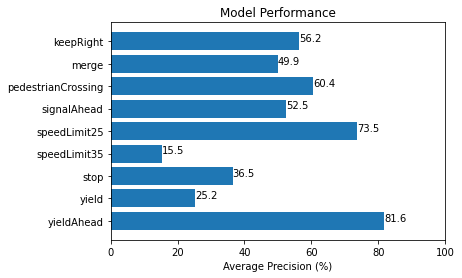

In [30]:
 # Construct model and load initial weights
model = FasterRCNNModel(
    num_classes = Dataset.num_classes,
    allow_edge_proposals = False,
    dropout_probability = 0
).cuda()


train(model = model)

In [34]:
def predict(model, image_data, image, show_image, output_path):
  image_data = t.from_numpy(image_data).unsqueeze(dim = 0).cuda()
  scored_boxes_by_class_index = model.predict(image_data = image_data, score_threshold = 0.7)
  show_detections(
    output_path = output_path,
    show_image = show_image,
    image = image,
    scored_boxes_by_class_index = scored_boxes_by_class_index,
    class_index_to_name = Dataset.class_index_to_name
  )

def predict_one(model, url, show_image, output_path):
  image_data, image, _, _ = load_image(url = url, min_dimension_pixels = 600)
  predict(model = model, image_data = image_data, image = image, show_image = show_image, output_path = output_path)

def predict_all(model, split):
  dirname = "predictions_" + split
  if not os.path.exists(dirname):
    os.makedirs(dirname)
  print("Rendering predictions from '%s' set to '%s'..." % (split, dirname))
  dataset = Dataset(dir = options.dataset_dir, split = split, augment = False, shuffle = False)
  for sample in iter(dataset):
    output_path = os.path.join(dirname, os.path.splitext(os.path.basename(sample.filepath))[0] + ".png")
    predict(model = model, image_data = sample.image_data, image = sample.image, show_image = False, output_path = output_path)


In [35]:
def predict_all(model, split):
  dirname = "predictions_" + split
  if not os.path.exists(dirname):
    os.makedirs(dirname)
  print("Rendering predictions from '%s' set to '%s'..." % (split, dirname))
  dataset = Dataset(dir = options.dataset_dir, split = split, augment = False, shuffle = False)
  for sample in iter(dataset):
    output_path = os.path.join(dirname, os.path.splitext(os.path.basename(sample.filepath))[0] + ".png")
    predict(model = model, image_data = sample.image_data, image = sample.image, show_image = False, output_path = output_path)

In [36]:
predict_all(model, "Test")

Rendering predictions from 'Test' set to 'predictions_Test'...
Wrote detection results to 'predictions_Test/sample_010.png'
Wrote detection results to 'predictions_Test/sample_011.png'
Wrote detection results to 'predictions_Test/sample_016.png'
Wrote detection results to 'predictions_Test/sample_018.png'
Wrote detection results to 'predictions_Test/sample_019.png'
Wrote detection results to 'predictions_Test/sample_021.png'
Wrote detection results to 'predictions_Test/sample_028.png'
Wrote detection results to 'predictions_Test/sample_034.png'
Wrote detection results to 'predictions_Test/sample_040.png'
Wrote detection results to 'predictions_Test/sample_041.png'
Wrote detection results to 'predictions_Test/sample_042.png'
Wrote detection results to 'predictions_Test/sample_057.png'
Wrote detection results to 'predictions_Test/sample_067.png'
Wrote detection results to 'predictions_Test/sample_073.png'
Wrote detection results to 'predictions_Test/sample_075.png'
Wrote detection result

In [ ]:



  # Perform mutually exclusive procedures
  if options.train:
    train(model = model)
  elif options.eval:
    evaluate(model = model, plot = options.plot, print_average_precisions = True)
  elif options.predict:
    predict_one(model = model, url = options.predict, show_image = True, output_path = None)
  elif options.predict_to_file:
    predict_one(model = model, url = options.predict_to_file, show_image = False, output_path = "predictions.png")
  elif options.predict_all:
    predict_all(model = model, split = options.predict_all)
  elif not options.dump_anchors:
    print("Nothing to do. Did you mean to use --train or --predict?")

In [ ]:
# Region Proposal Network Arcihtecture


class RPN(nn.Module):
    def __init__(self):
        super(RPN, self).__init__()

        # VGG
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # We are not using fully connected layers (3 fc layers) as we need feature maps as output from this network.


        # VGG16 Architecture Used for Creating Feature Maps, Now the RPN Layer. Number of Anchors = 9

        self.rpn_layer = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),
            nn.ReLU()
        )

        self.class_layer = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=9, kernel_size=1),
            nn.Sigmoid()#0 or 1 to get label is in anchorbox or not
        )
        
        self.regr_layer = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=36, kernel_size=1),
            nn.Linear(in_channels=512, out_channels=36)
        )



        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)

            out = self.rpn_layer(out)

            out_class = self.class_layer(out)

            out_regr = self.regr_layer(out)

            return [out_class, out_regr, out] #classification object(0,1) in the anchor boxes and bounding boxes

            





In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x